In [1]:
!pip install --proxy http://hpeproxy.its.hpecorp.net:80 mlflow==2.4.0

In [1]:
import warnings
warnings.filterwarnings('ignore')
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
%matplotlib inline
warnings.filterwarnings('ignore')


In [2]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [3]:
config = {
    "KSERVE_MODEL_NAME": "bank-demo-10-010823",
    "SERVICE_ACCOUNT": "kserve-minio-sa"
}

In [4]:
import requests
EZAF_ENV = "hpe-apps-dev2-ezaf"
token_url = f"https://keycloak.{EZAF_ENV}.com/realms/UA/protocol/openid-connect/token"

data = {
    "username" : input("Enter username."),
    "password" : input("Enter password."),
    "grant_type" : "password",
    "client_id" : "ua-grant",
}

token_responce = requests.post(token_url, data=data, allow_redirects=True, verify=False)

token = token_responce.json()["access_token"]

minio_username = input("Enter data fabric object store Access Key.")
minio_password = input("Enter data fabric object store Secret Access Key.")

Enter username. hpedemo-user01
Enter password. Hpepoc@123
Enter data fabric object store Access Key. minioadmin
Enter data fabric object store Secret Access Key. minioadmin


In [5]:
import pandas as pd
import numpy as np
import boto3
import io
import joblib
from sklearn.feature_selection import  SelectKBest, f_classif
import matplotlib.pyplot as plt 
import seaborn as sns
from imblearn import under_sampling,over_sampling
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from sklearn.preprocessing  import power_transform, StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression, SGDRegressor,Ridge, Lasso
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score,classification_report, confusion_matrix,plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
import pickle
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from mlflow.tracking import MlflowClient
import mlflow, urllib3
import subprocess

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://home.hpe-apps-dev2-ezaf.com:31900"
os.environ['MLFLOW_TRACKING_TOKEN'] = token
os.environ["MLFLOW_TRACKING_URI"] = "https://mlflow.hpe-apps-dev2-ezaf.com"
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"
os.environ["MLFLOW_S3_IGNORE_TLS"] = "true"
os.environ["AWS_ACCESS_KEY_ID"] = minio_username
os.environ["AWS_SECRET_ACCESS_KEY"] = minio_password

In [6]:
# Adding package to env
# pip_reqs = mlflow.sklearn.get_default_pip_requirements()
# pip_reqs += ['dill']

EXPERIMENT_NAME = config["KSERVE_MODEL_NAME"]
mlflow.set_experiment(EXPERIMENT_NAME)
EXPERIMENT_ID = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

In [7]:
%matplotlib inline

In [8]:
# Set up AWS credentials and create S3 client
session = boto3.Session(
aws_access_key_id='minioadmin',
aws_secret_access_key='minioadmin',
)
s3 = session.client('s3',endpoint_url='https://home.hpe-apps-dev2-ezaf.com:31900',verify=False)
from datetime import datetime

today = datetime.today().strftime('%Y-%m-%d')

# TODO: Delete code line below
today = "2023-07-11"

# Specify bucket name and folder path
bucket_name = 'bank'
folder_path = f'merged_data{today}'

# List objects in the folder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)
print(response)
file_objects = response['Contents']

# Print the names of all files in the folder
print("Files in the folder:")
for file in file_objects:
    file_name = file['Key']
    print(file_name)
# Filter and select the CSV file in the folder
csv_files = [file for file in file_objects if file['Key'].lower().endswith('.csv')]

if len(csv_files) == 1:
    csv_file = csv_files[0]
    file_key = csv_file['Key']

# Download CSV file from S3 and load into DataFrame
csv_data = s3.get_object(Bucket=bucket_name, Key=file_key)['Body'].read().decode('utf-8')
df = pd.read_csv(io.StringIO(csv_data))
# Read the Dataset
# df = pd.read_csv("merged.csv")
df
df.head(25)
df.size
df.dtypes
df.shape
df.info()
df.columns

{'ResponseMetadata': {'RequestId': '17790623874FDD79', 'HostId': '', 'HTTPStatusCode': 200, 'HTTPHeaders': {'accept-ranges': 'bytes', 'content-length': '705', 'content-security-policy': 'block-all-mixed-content', 'content-type': 'application/xml', 'server': 'MinIO', 'vary': 'Origin', 'x-amz-request-id': '17790623874FDD79', 'x-xss-protection': '1; mode=block', 'date': 'Mon, 07 Aug 2023 06:31:24 GMT'}, 'RetryAttempts': 0}, 'IsTruncated': False, 'Contents': [{'Key': 'merged_data2023-07-11/part-00000-3caa6459-6f1b-4a91-a522-5bdd770eb3e6-c000.csv', 'LastModified': datetime.datetime(2023, 8, 2, 5, 1, 1, 451000, tzinfo=tzlocal()), 'ETag': '"b7aab53158f588e5ad81753622fe0366"', 'Size': 418529, 'StorageClass': 'STANDARD', 'Owner': {'DisplayName': 'minio', 'ID': '02d6176db174dc93cb1b899f7c6078f08654445fe8cf1b6ce98d8855f66bdbf4'}}], 'Name': 'bank', 'Prefix': 'merged_data2023-07-11', 'Delimiter': '', 'MaxKeys': 4500, 'EncodingType': 'url', 'KeyCount': 1}
Files in the folder:
merged_data2023-07-11/p

Index(['age', 'job', 'marital', 'education', 'default1', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'target'],
      dtype='object')

<Axes: >

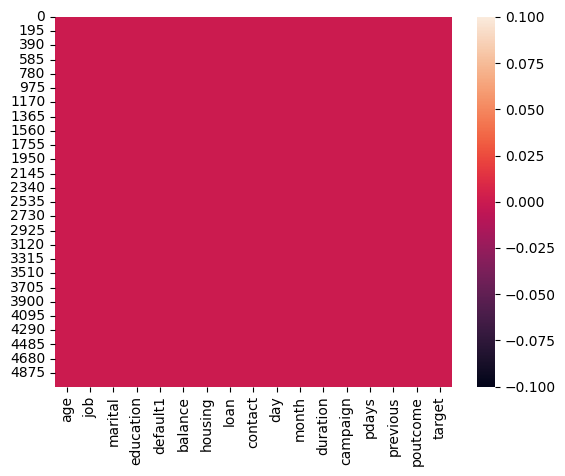

In [9]:
#checking Null Values in the dataset
df.isnull()

#checking the sum of the Dataset
df.isnull().sum()

#checking Null values by heatmap
sns.heatmap(df.isnull())

In [10]:
#checking any space in the dataset 

(df == ' ?')
(df == ' ?').sum()
#Or
(df == ' ').sum()
#checking any null value in the target column
df[df['target'] == '']
df[df['target'] == ''].index
df['target'].value_counts()
df['target'].unique()
df.nunique()

age            68
job            13
marital         3
education       4
default1        2
balance      2832
housing         2
loan            2
contact         3
day            31
month          12
duration     1272
campaign       50
pdays         542
previous       25
poutcome        4
target          2
dtype: int64

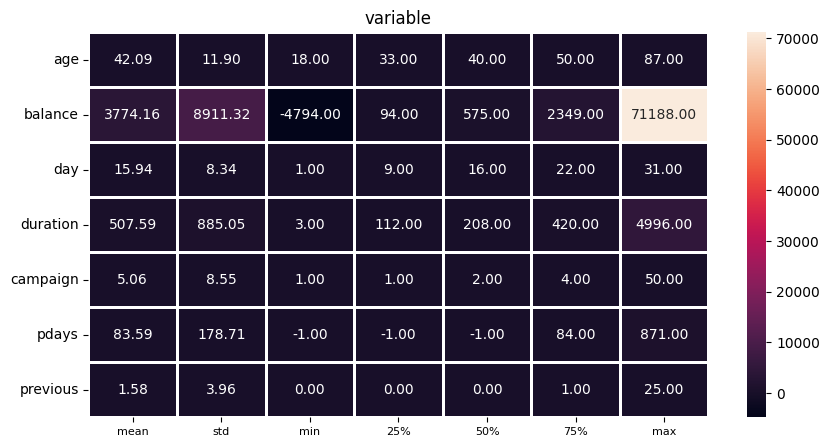

In [11]:
df.describe()
plt.figure(figsize=(10,5))
sns.heatmap(round(df.describe()[1:].transpose(),2),linewidth=2,annot=True,fmt='.2f')
plt.xticks(fontsize=14)
plt.xticks(fontsize=8)
plt.title('variable')
plt.show()

no     4253
yes     808
Name: target, dtype: int64


<Axes: xlabel='target', ylabel='Count'>

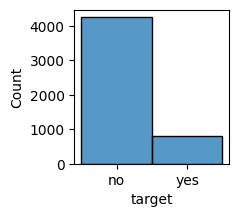

In [12]:
# Data Cleaning and Preprocessing
df['age'].value_counts()
df['age'].unique()
#Histplot for "tenure" column
print(df["target"].value_counts())
plt.figure(figsize=(2,2))
sns.histplot(x='target',data=df,bins=73)

<Axes: xlabel='target', ylabel='count'>

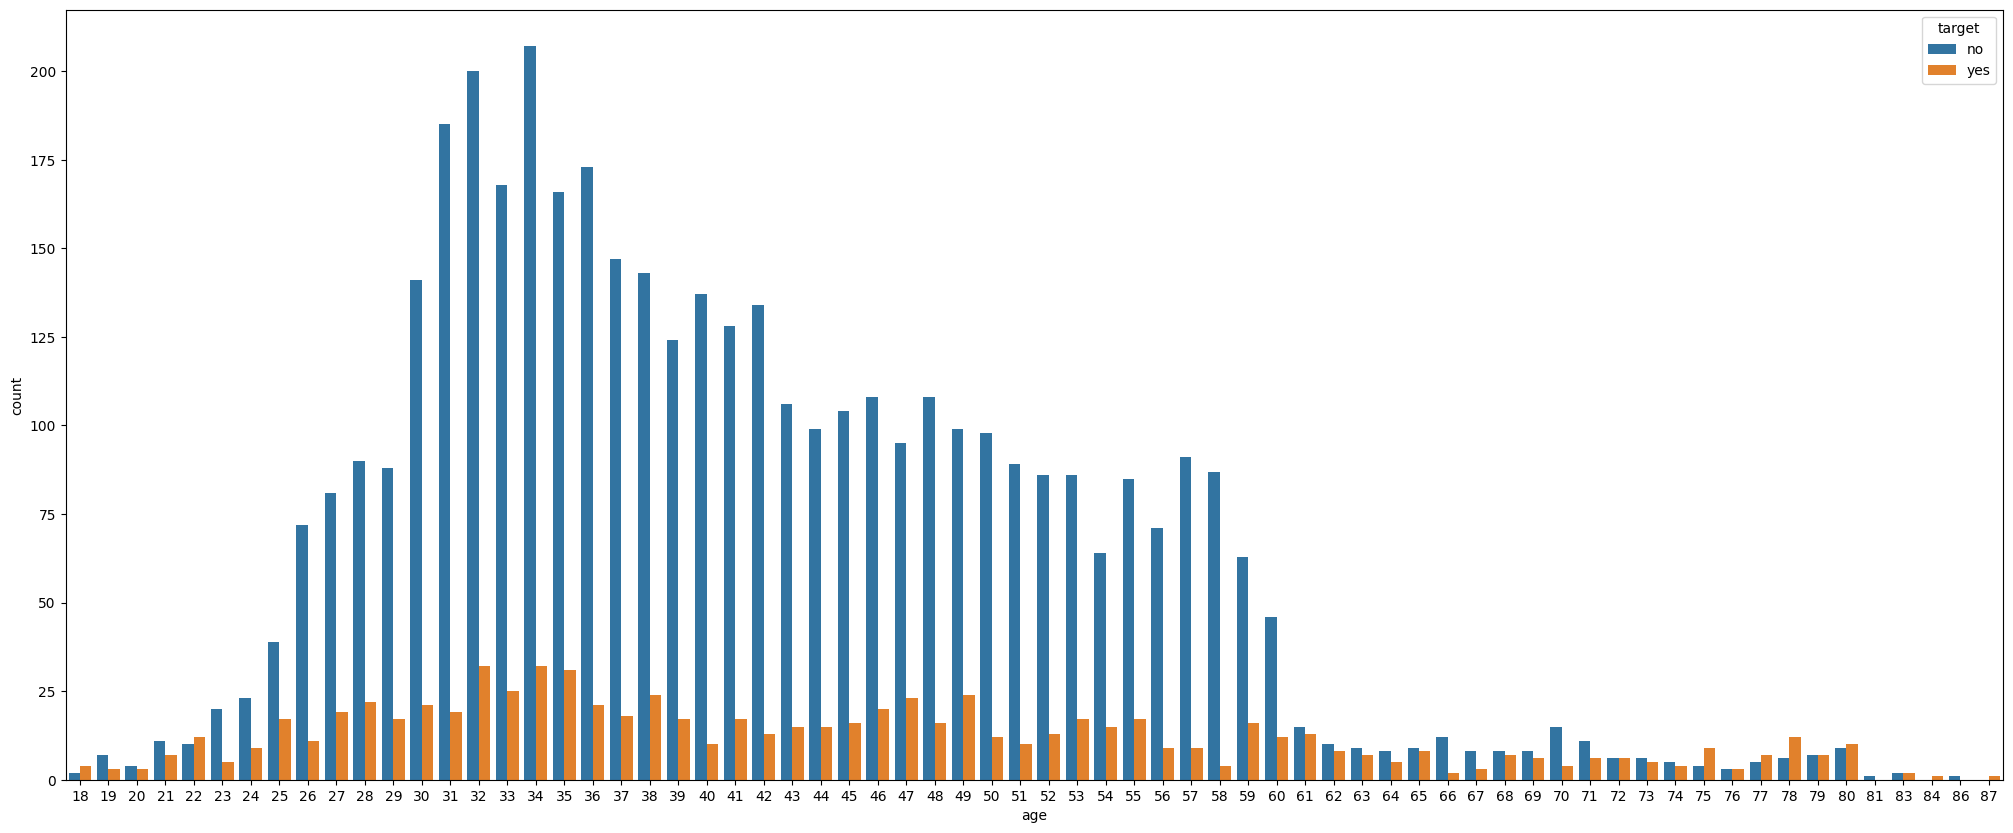

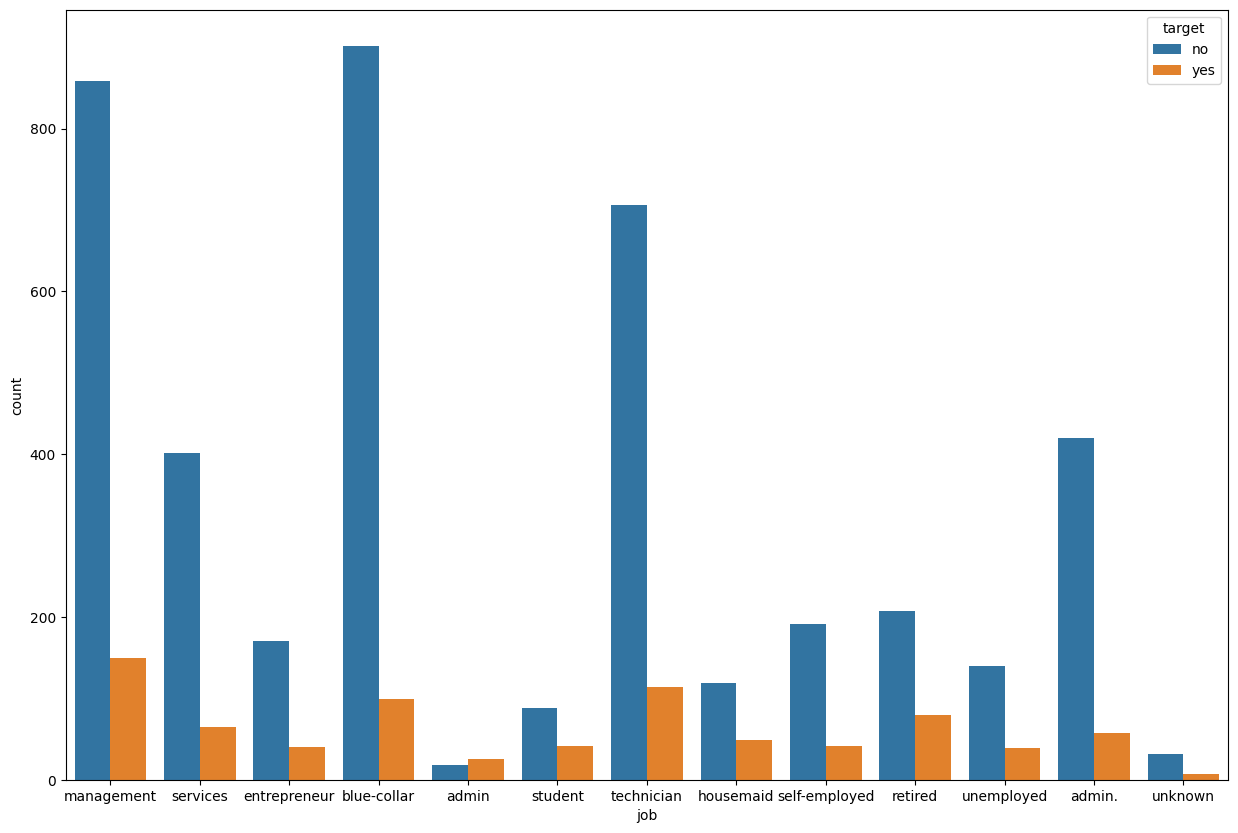

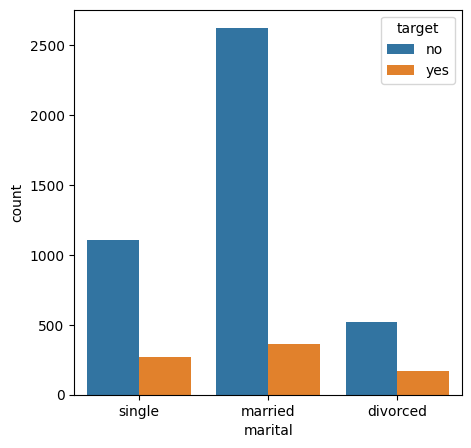

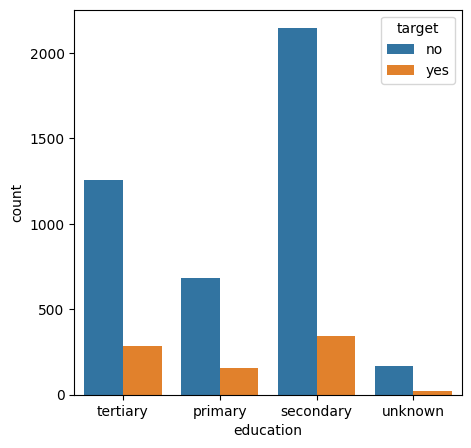

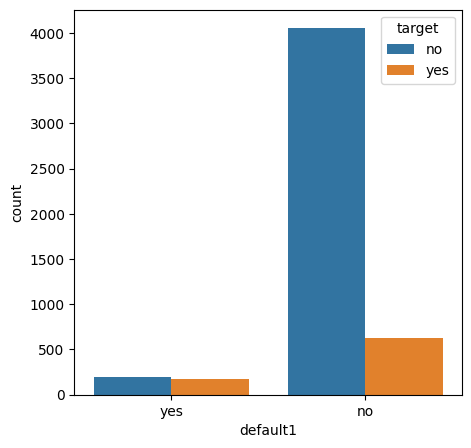

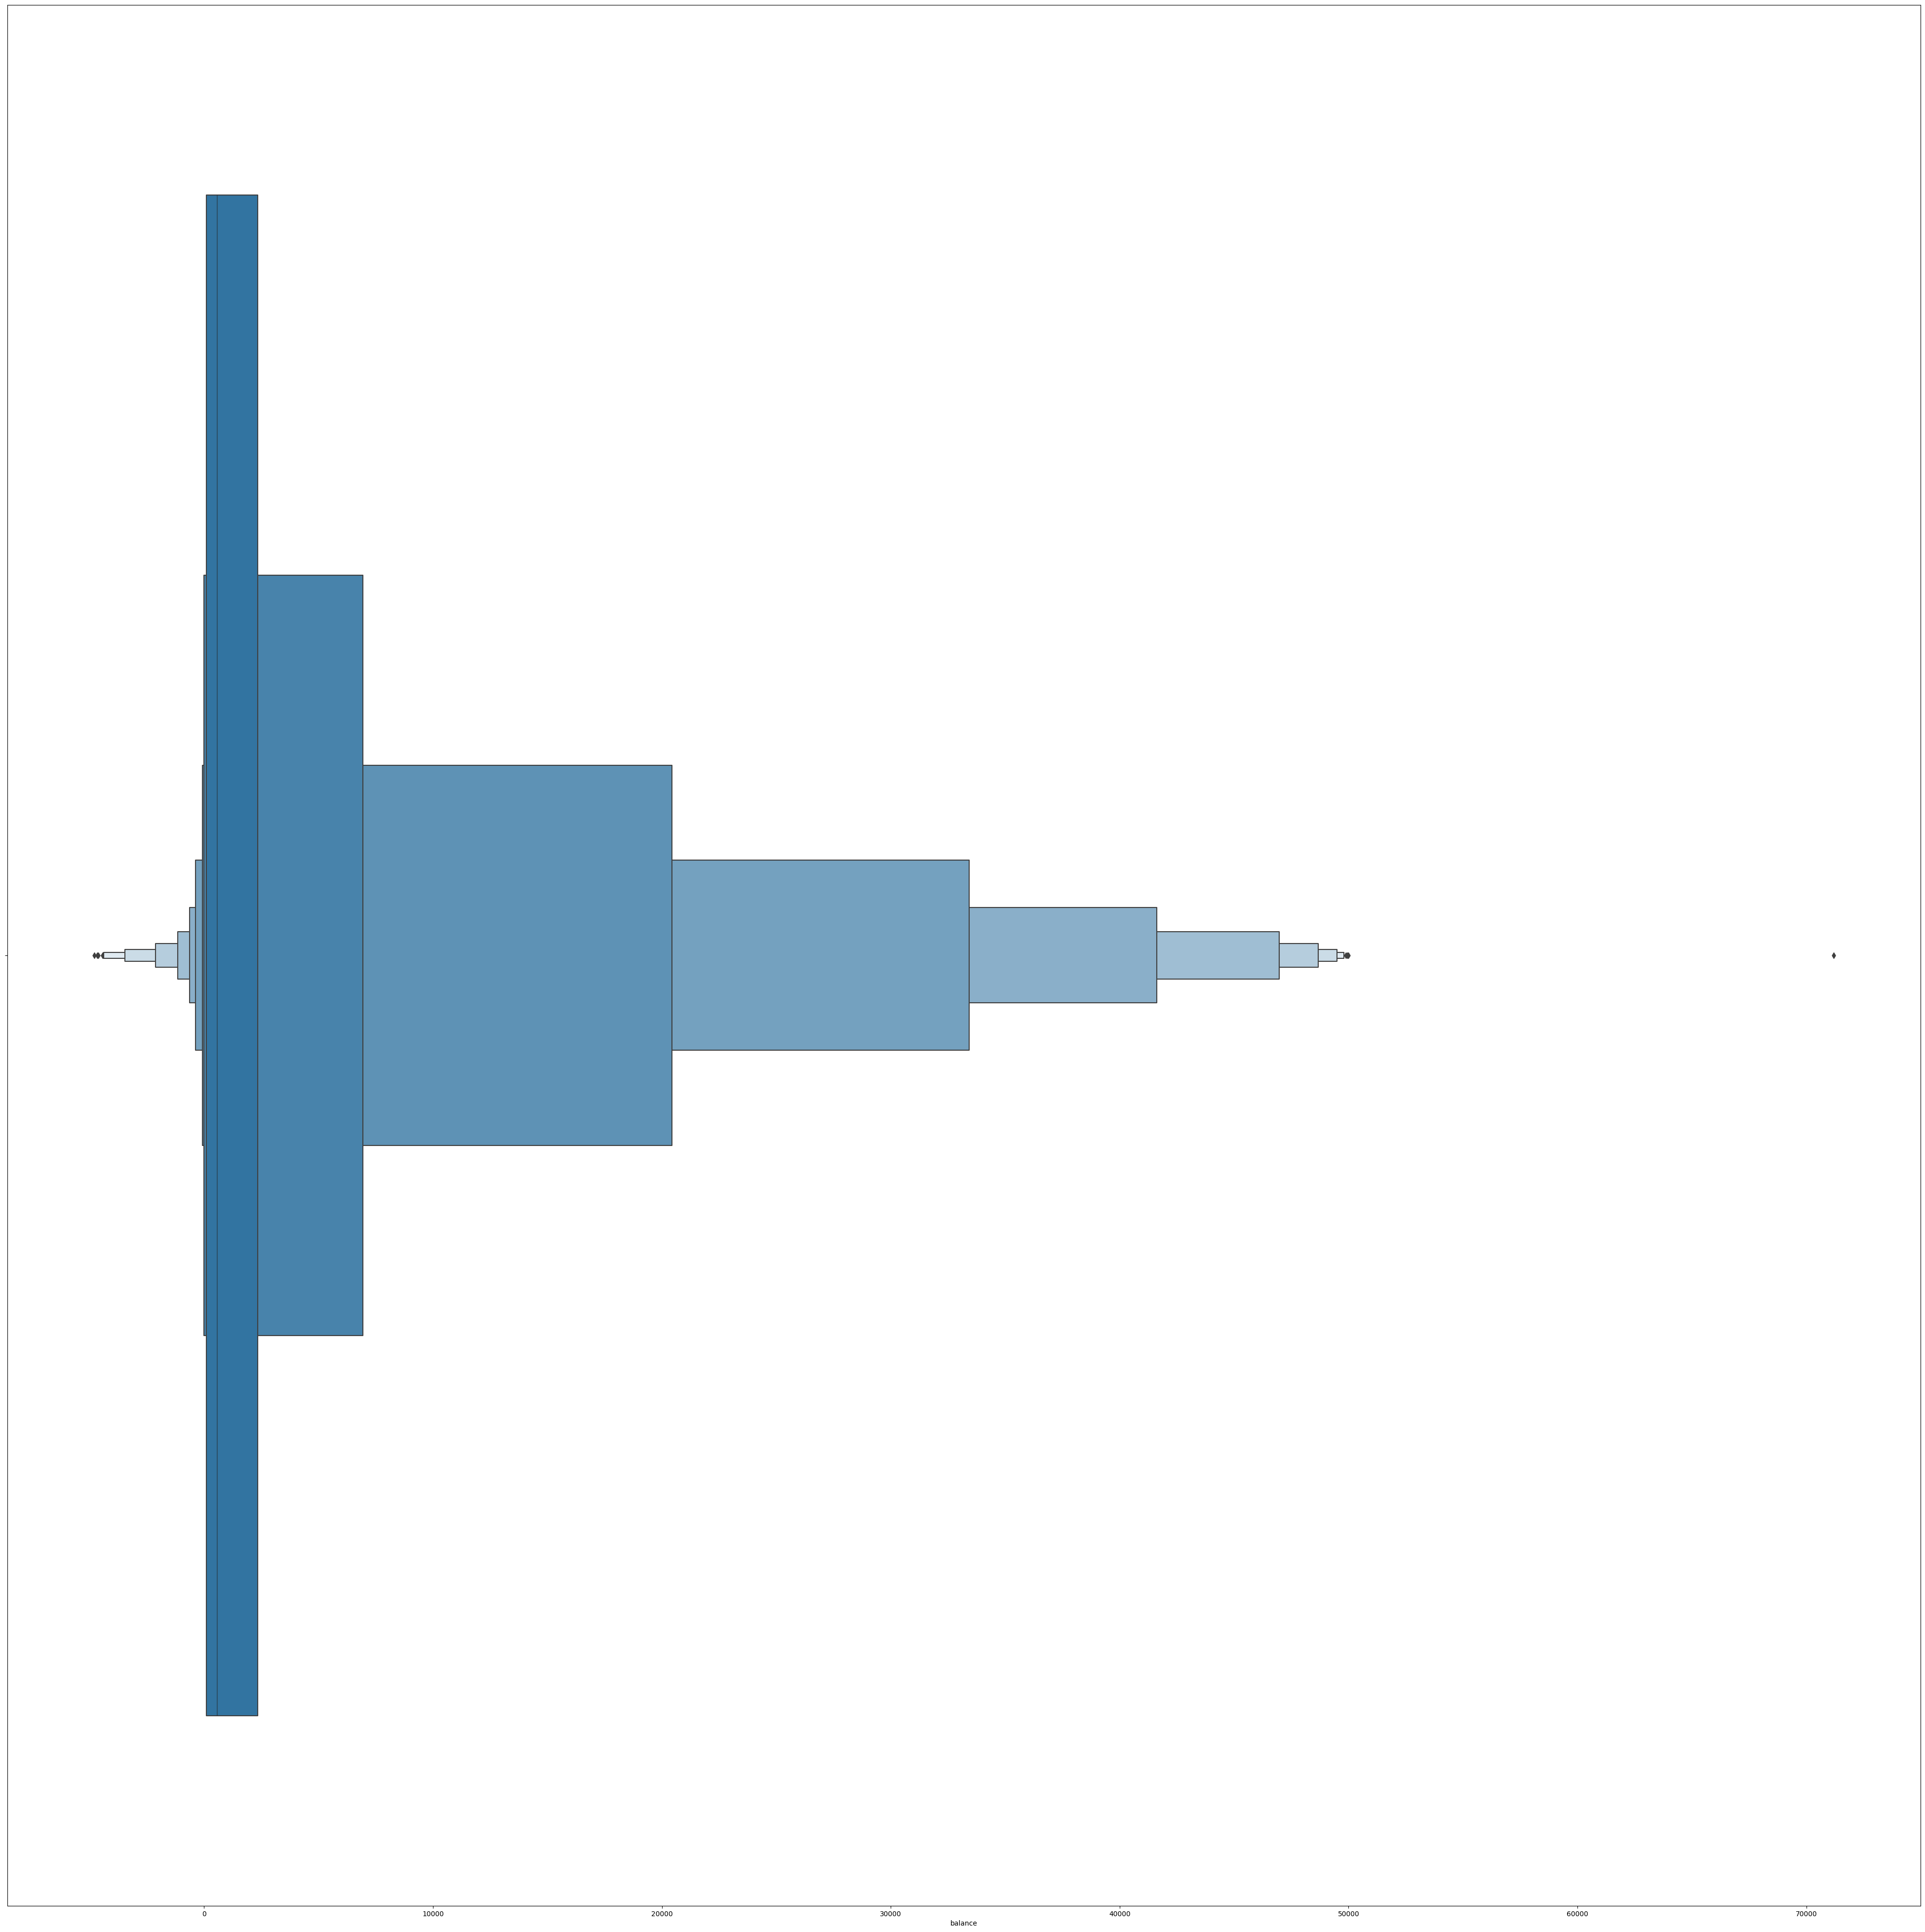

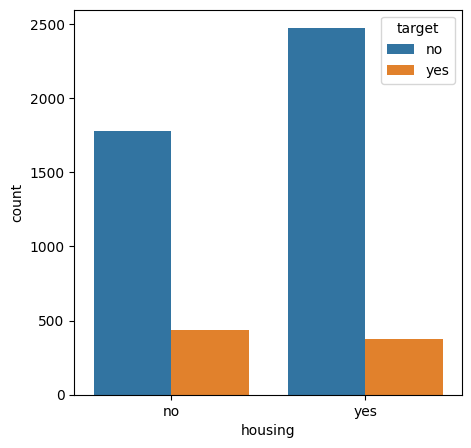

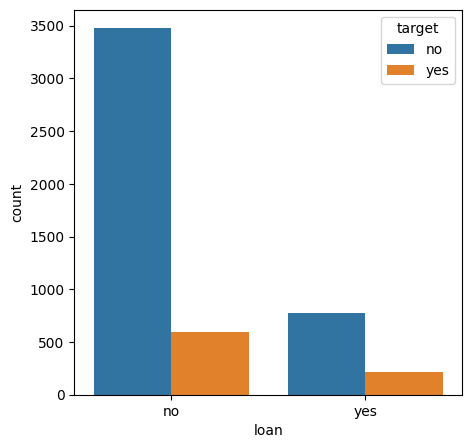

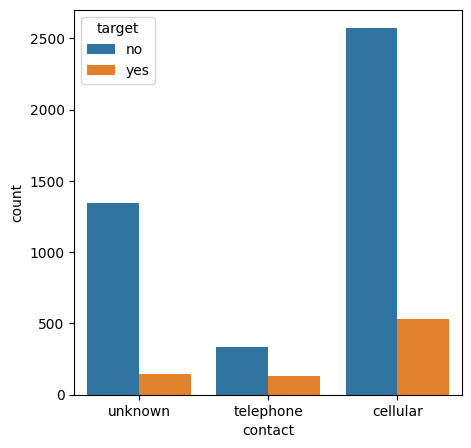

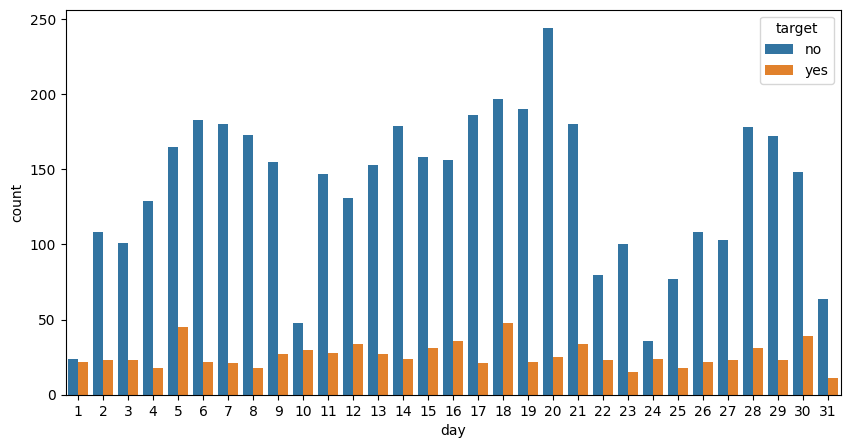

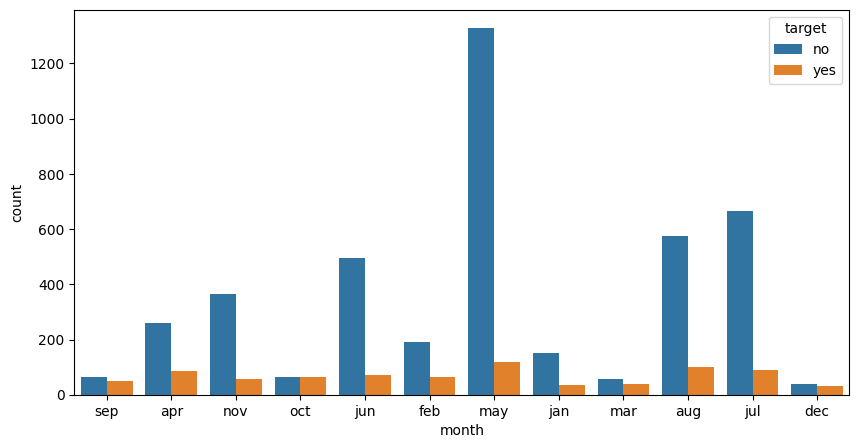

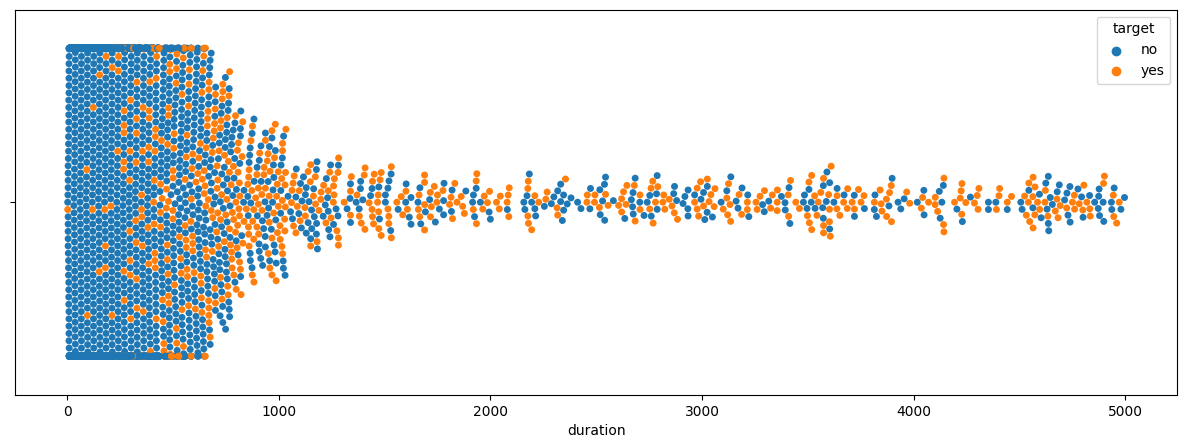

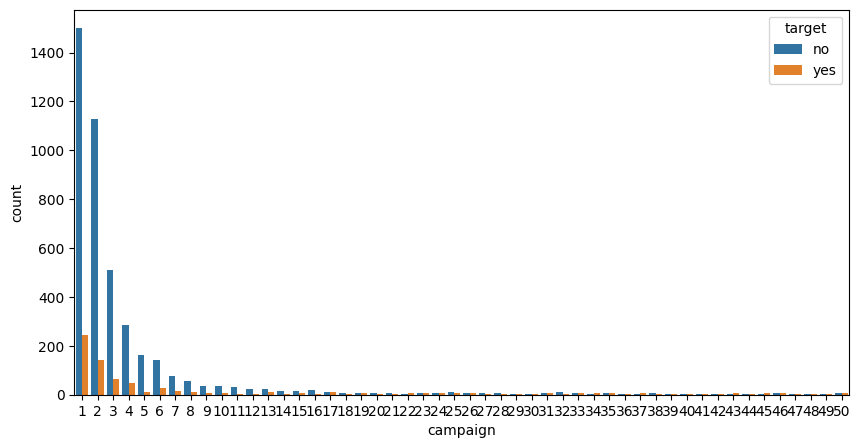

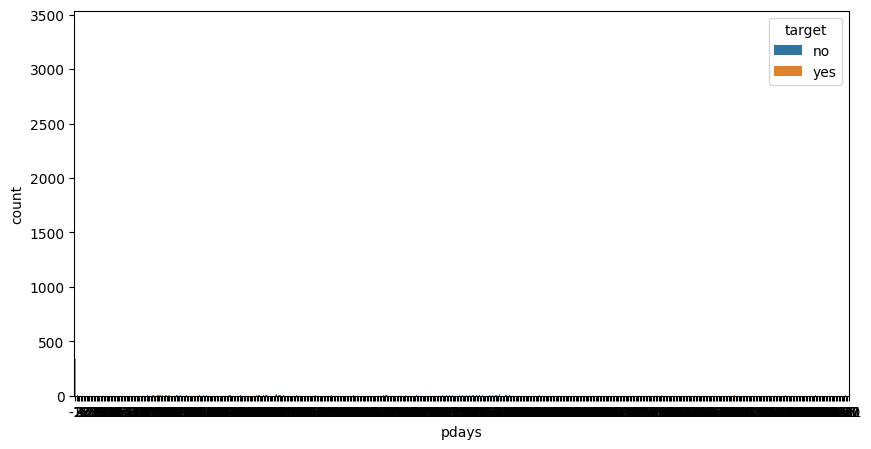

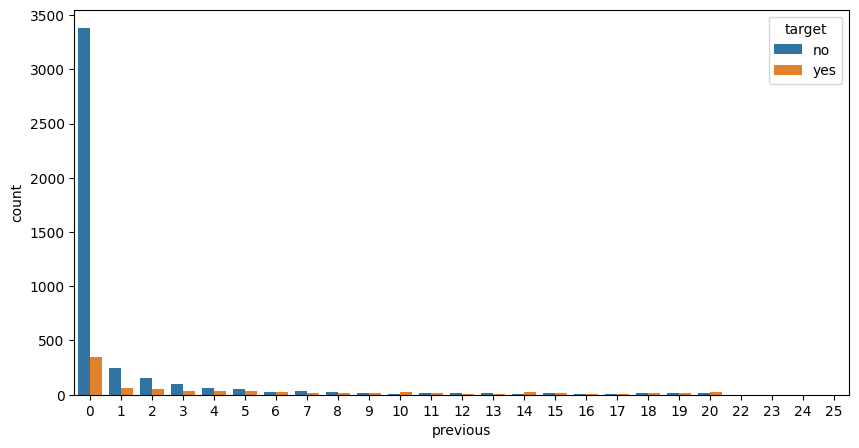

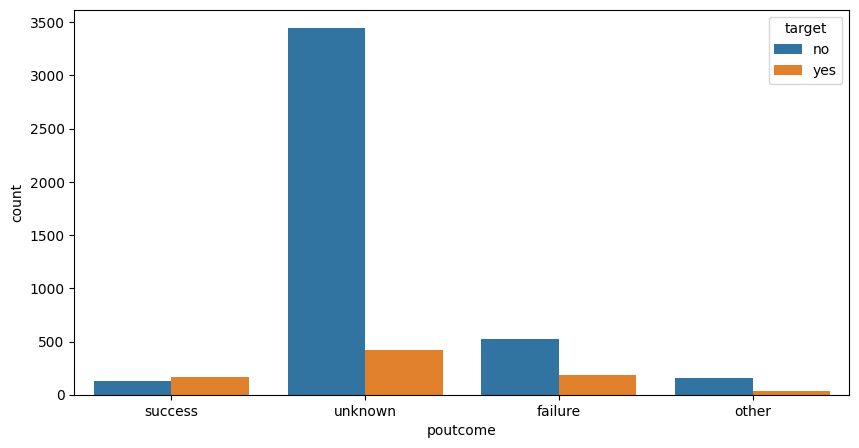

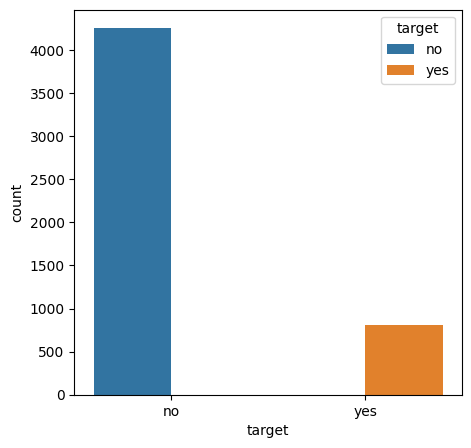

In [13]:
#  Bivariate Analysis
plt.figure(figsize=(25,10))
sns.countplot(x='age', data=df, hue='target')

plt.figure(figsize=(15,10))
sns.countplot(x='job', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='marital', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='education', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='default1', data=df,hue='target')

plt.figure(figsize=(50,50))
sns.boxenplot(x='balance', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='housing', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='loan', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='contact', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='day', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='month', data=df,hue='target')

plt.figure(figsize=(15,5))
sns.swarmplot(x='duration', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='campaign', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='pdays', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='previous', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='poutcome', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='target', data=df,hue='target')

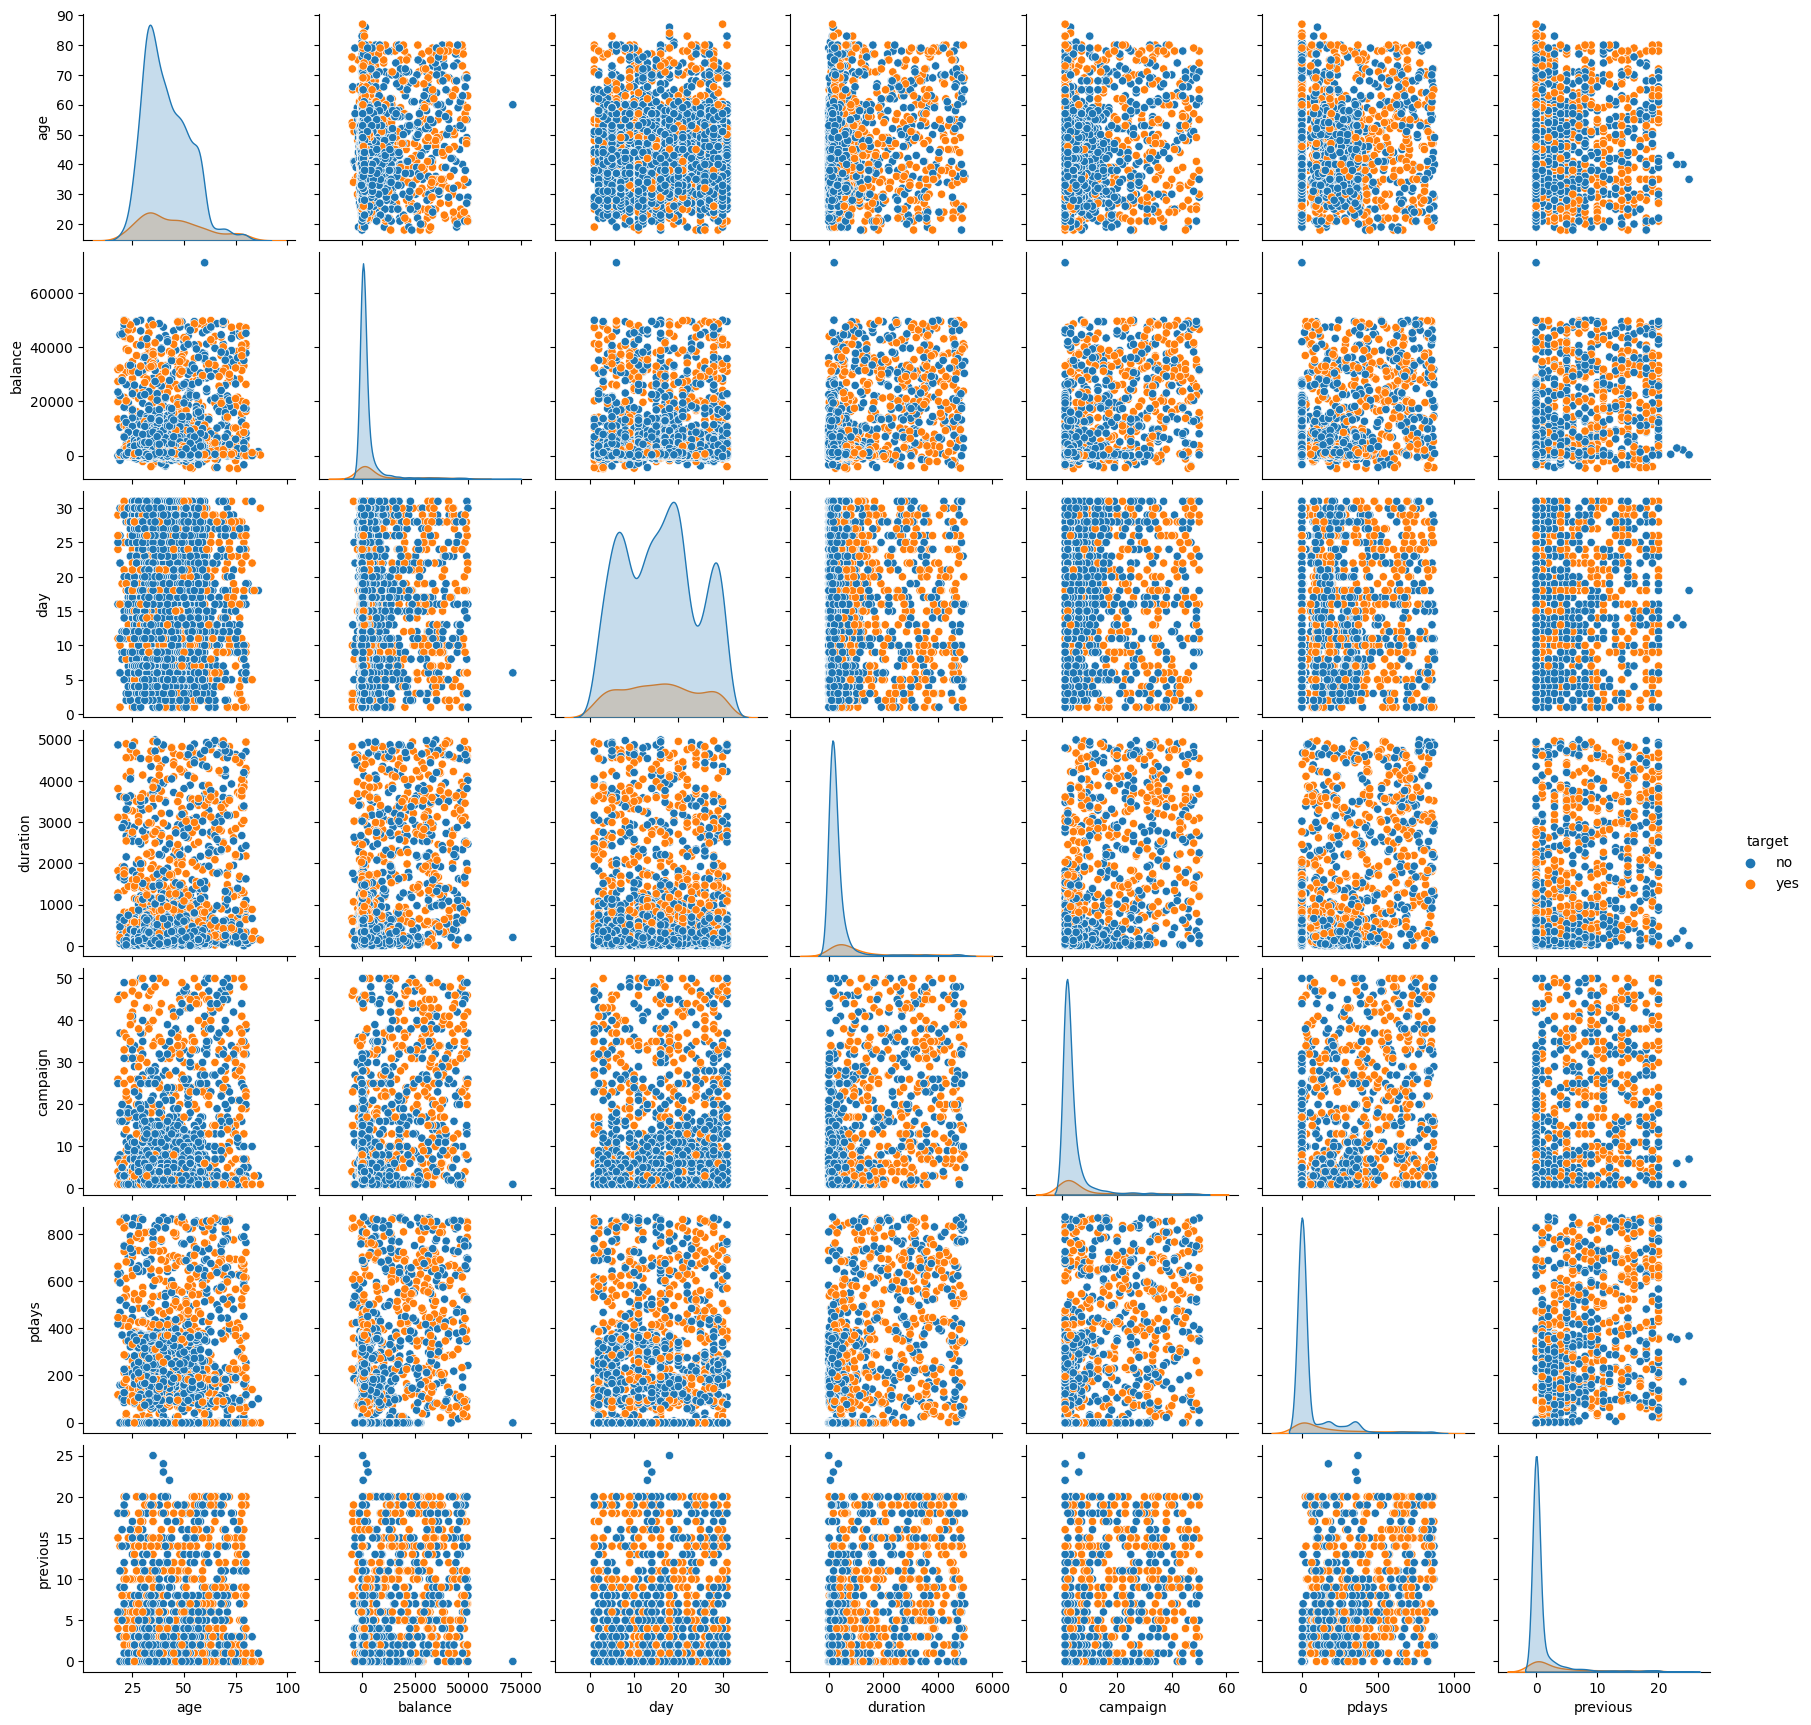

In [14]:
sns.pairplot(df,hue='target')

In [15]:
enc = LabelEncoder()
for i in df.columns:
    if df[i].dtypes =='object':
        df[i]=enc.fit_transform(df[i].values.reshape(-1,1))

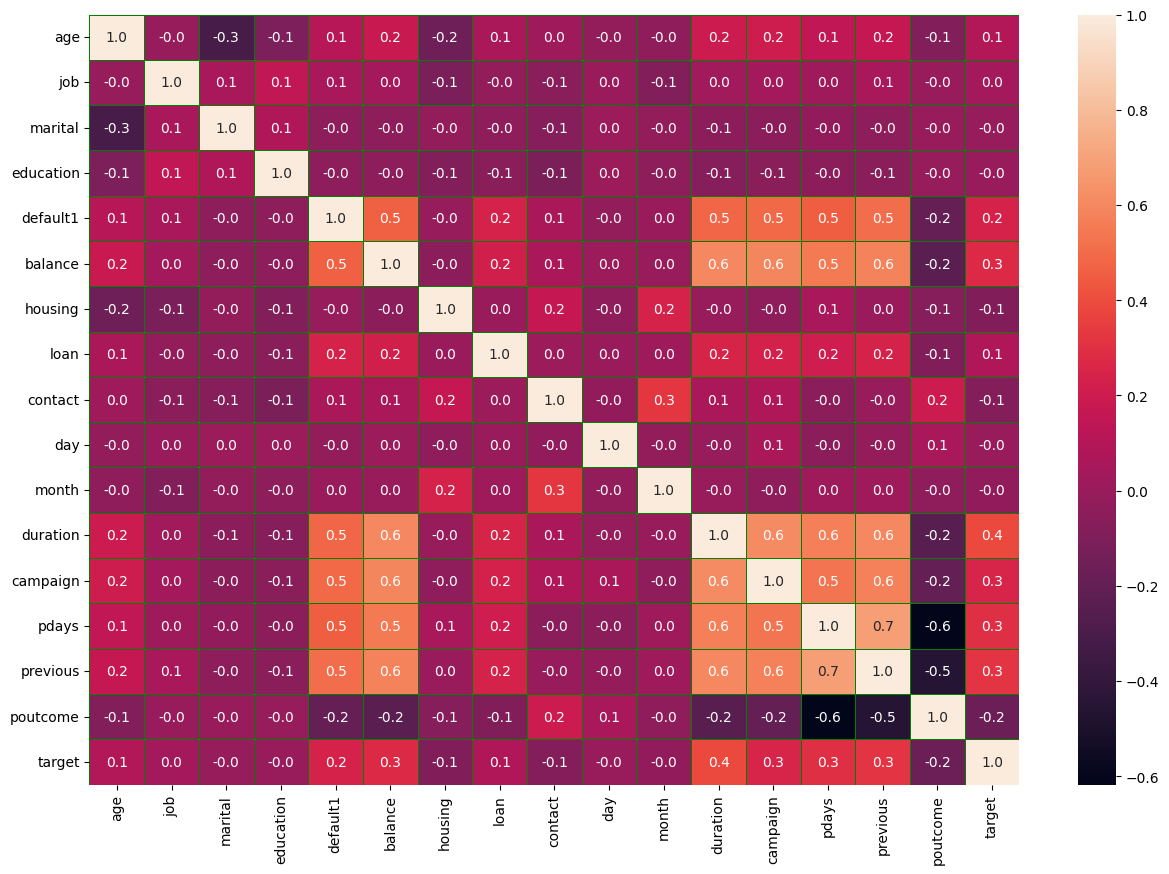

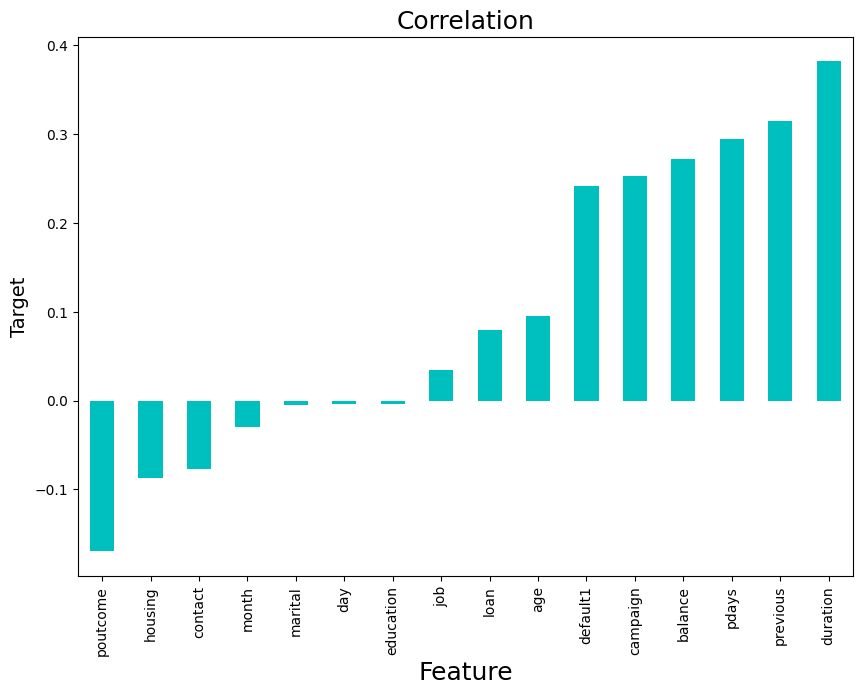

In [16]:
#  Checking Correlation
df.head(50)
df.corr()
df.corr()['target'].sort_values()

# Checking Correlation with Heatmap

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True, linewidths=0.5,linecolor='green',fmt='.1f')

#  Checking Correlation with barplot
plt.figure(figsize=(10,7))
df.corr()['target'].sort_values(ascending=True).drop(['target']).plot(kind='bar',color = 'c')
plt.xlabel('Feature',fontsize=18)
plt.ylabel('Target',fontsize=14)
plt.title('Correlation',fontsize = 18)
plt.show()

In [17]:
# We can observe :
# All columns are sorted in ascending order showing least to strong correlation with target column. 
# 13 columns are negatively correlated and 7 columns are positively correlated. Column 'MonthlyCharges' 
# is highly correlated with Target column 'Churn' and Column 'Contract' is least correlated with Target column 'Churn'.

age          0.766592
job          0.201359
marital     -0.106270
education    0.135743
default1     3.236636
balance      3.356140
housing     -0.252203
loan         1.530413
contact      0.669907
day          0.082110
month       -0.421256
duration     3.262007
campaign     3.280323
pdays        2.445342
previous     3.112438
poutcome    -1.627539
target       1.858937
dtype: float64

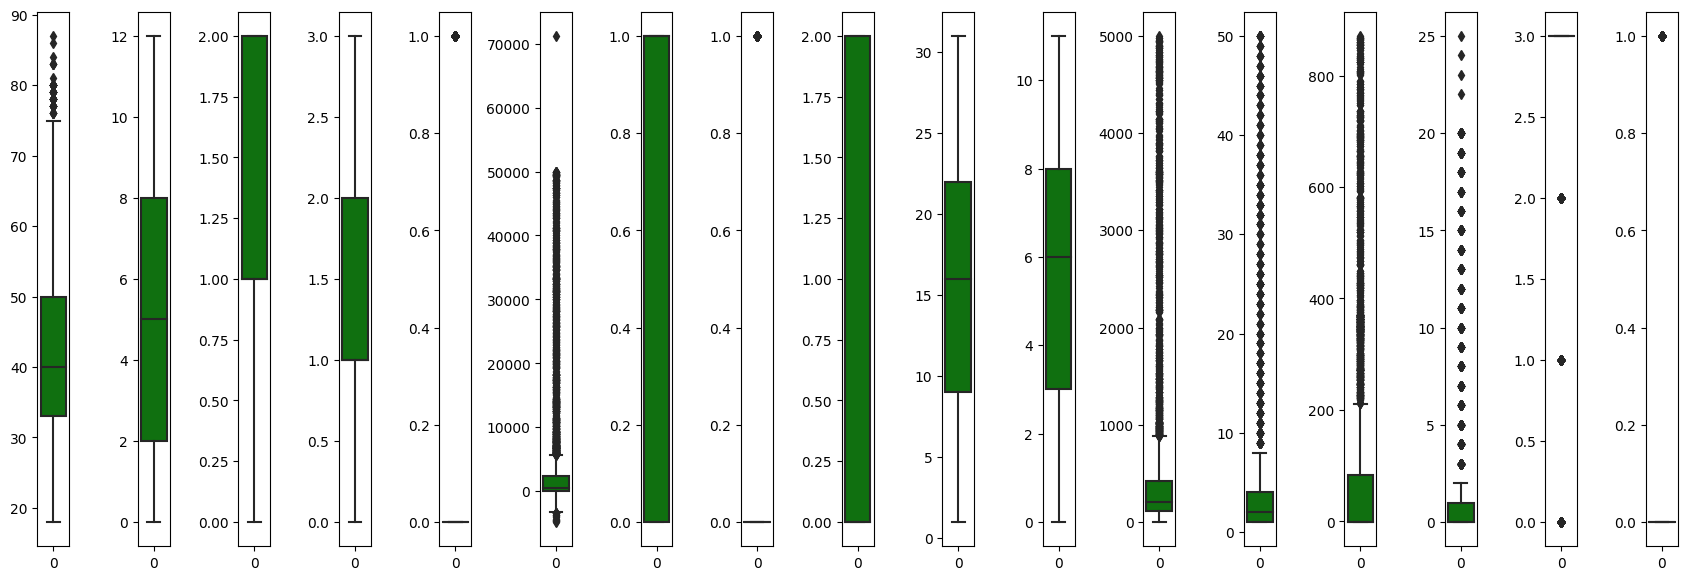

In [18]:
# Checking Outliers
collist=df.columns.values
ncol=21
nrows=11
plt.figure(figsize=(ncol,3*ncol))
for column in range(0,len(collist)):
    plt.subplot(nrows,ncol,column+1)
    sns.boxplot(data=df[collist[column]],color='green',orient='v')
  #  plt.xlabel(column,frontsize = 15)
    plt.tight_layout()
df.skew()

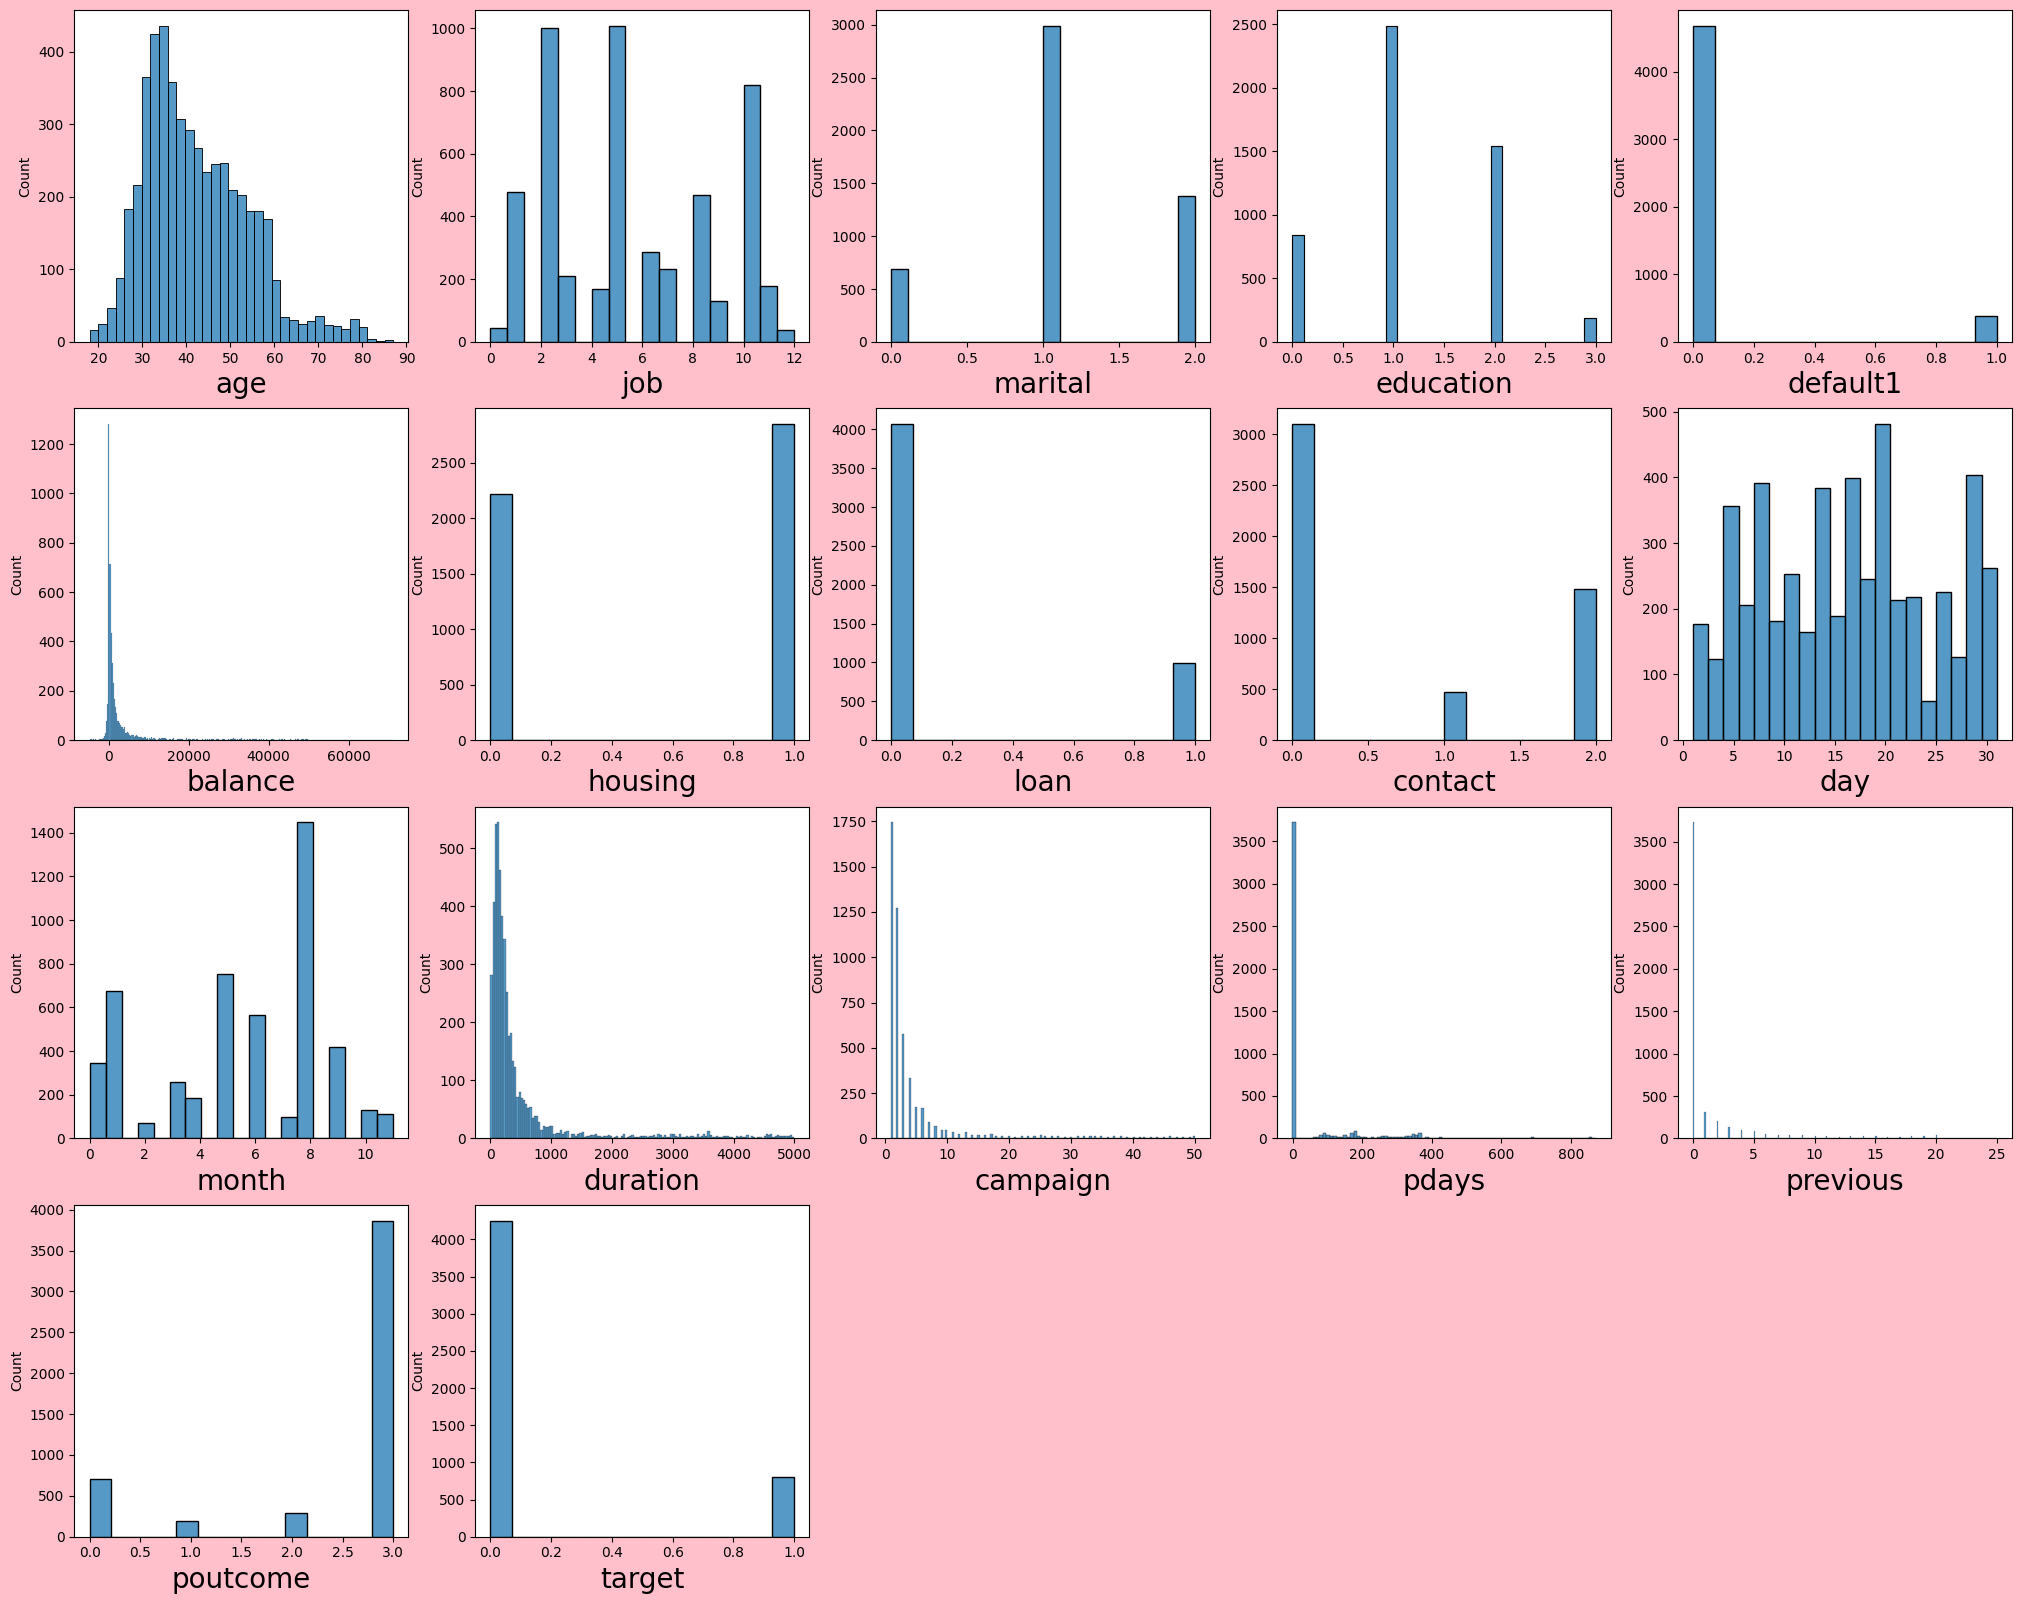

In [19]:
plt.figure(figsize=(25,25), facecolor='pink')
plotnumber = 1

for column in df:
    if plotnumber<=21:
        ax = plt.subplot(5,5,plotnumber)
        sns.histplot(df[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.show()

<Axes: xlabel='poutcome', ylabel='Density'>

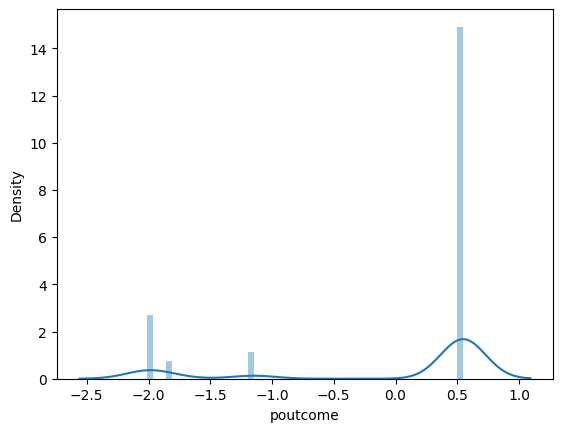

In [20]:
collist = ['poutcome']
df[collist]=power_transform(df[collist],method='yeo-johnson')
df[collist]
df.skew()
sns.distplot(df['poutcome'])

In [21]:
# Data Preprocessing
x=df.drop("target",axis=1)
y=df["target"]
x.columns
x.head(10)
y.head(10)
x.shape
y.shape
y.value_counts()
SM = SMOTE()
x, y = SM.fit_resample(x,y)
y.value_counts()

0    4253
1    4253
Name: target, dtype: int64

In [22]:
# Scaling data using Standard Scaler
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)
x.head()
x
var_threshold = VarianceThreshold(threshold=0)
var_threshold.fit(x)

var_threshold.get_support()
x.columns[var_threshold.get_support()]

# taking  out  all the  constant  columns 
cons_columns = [column for column in x.columns
               if column not in x.columns[var_threshold.get_support()]]
print(len(cons_columns))

0


In [23]:
# SelectKBest method
best_fit = SelectKBest(score_func = f_classif, k ='all')
fit = best_fit.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
fit = best_fit.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
dfcolumns.head()
featureScores = pd.concat([dfcolumns,dfscores],axis = 1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(12,'Score'))

      Feature        Score
11   duration  1622.379804
13      pdays  1023.548497
14   previous   990.607504
6     housing   906.171512
5     balance   778.546912
15   poutcome   675.531645
12   campaign   607.672568
8     contact   514.438828
2     marital   362.664615
3   education   277.198973
4    default1   173.743457
0         age    98.816975


In [24]:
# VIF(Variance Inflation factor)
vif = pd.DataFrame()
vif['VIF values'] = [variance_inflation_factor(x.values,i)for i in range(len(x.columns))]
vif['features'] = x.columns
vif


VIF values   features
0     1.169407        age
1     1.037831        job
2     1.114194    marital
3     1.085893  education
4     1.357868   default1
5     2.248218    balance
6     1.131866    housing
7     1.137081       loan
8     1.212535    contact
9     1.012991        day
10    1.128205      month
11    2.263702   duration
12    2.474395   campaign
13    3.166465      pdays
14    2.690626   previous
15    1.838414   poutcome

In [25]:
# Creating Model
maxAccu = 0
maxRS = 0
for i in range(1,100):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.30, random_state =i)
    DTC = DecisionTreeClassifier()
    DTC.fit(x_train,y_train)
    pred = DTC.predict(x_test)
    acc = accuracy_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print('Best Accuracy is :- ', maxAccu, 'on Random State :- ',maxRS)

Best Accuracy is :-  0.872257053291536 on Random State :-  60


In [26]:
# Creating train-test Split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.15,random_state=maxRS)
x.shape
y.shape
x_train.shape,y_train.shape, x_test.shape,y_test.shape

((7230, 16), (7230,), (1276, 16), (1276,))

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

  RMSE: 0.4363930240887842
  MAE: 0.19043887147335423
  R2: 0.23792811059907837
  Accuracy: 79.5


Found credentials in environment variables.


Accuracy Score:-  0.8095611285266457
Confusion Matrix :- 
  [[511 114]
 [129 522]]
Classification Report :- 
                precision    recall  f1-score   support

           0       0.80      0.82      0.81       625
           1       0.82      0.80      0.81       651

    accuracy                           0.81      1276
   macro avg       0.81      0.81      0.81      1276
weighted avg       0.81      0.81      0.81      1276



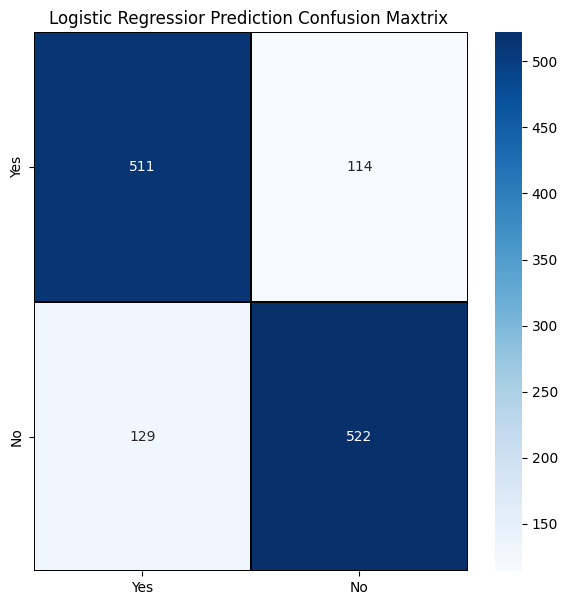

In [28]:
# Logistic Regression
with mlflow.start_run(run_name='Logistic Regression', experiment_id=EXPERIMENT_ID):
    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)

    predicted_qualities = logreg.predict(x_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(logreg.score(x, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(logreg, "model")
    print('Accuracy Score:- ', accuracy_score(y_test,predicted_qualities))

    print('Confusion Matrix :- \n ', confusion_matrix(y_test,predicted_qualities))

    print('Classification Report :- \n ',classification_report(y_test,predicted_qualities))

    ### Here we are getting 85% accuracy using Logistic Regression.
    ## Confusion Matrix for Logistic Regression

    cm = confusion_matrix(y_test,predicted_qualities)
    x_axis_labels = ['Yes', 'No']
    y_axis_labels = ['Yes', 'No']
    f,ax = plt.subplots(figsize = (7,7))
    sns.heatmap(cm,annot = True, linewidths=.2,linecolor='black',fmt= '.0f',ax=ax, cmap = 'Blues',xticklabels=x_axis_labels,yticklabels=y_axis_labels)
    plt.title('Logistic Regressior Prediction Confusion Maxtrix ')
    mlflow.end_run()

  RMSE: 0.3002089136743441
  MAE: 0.09012539184952978
  R2: 0.6393486943164363
  Accuracy: 98.65
Random Forest Accuracy Score is:- 
 
   0.9098746081504702

 Confusion Matrix is :-
   [[557  68]
 [ 47 604]]

 Classification Report is 
                 precision    recall  f1-score   support

           0       0.92      0.89      0.91       625
           1       0.90      0.93      0.91       651

    accuracy                           0.91      1276
   macro avg       0.91      0.91      0.91      1276
weighted avg       0.91      0.91      0.91      1276



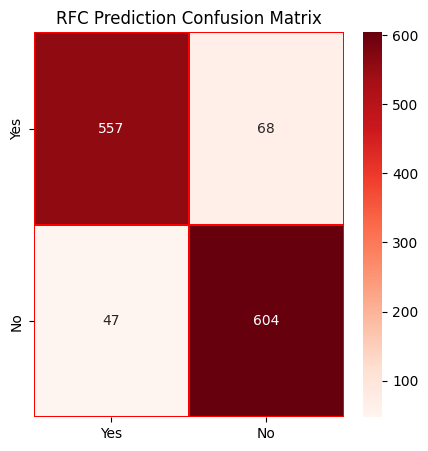

In [29]:
# Classification Algorithms 
## Random Forest Classifier
with mlflow.start_run(run_name='Random Forest Classifier', experiment_id=EXPERIMENT_ID):
    random_forest = RandomForestClassifier()
    random_forest.fit(x_train, y_train)

    predicted_qualities = random_forest.predict(x_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(random_forest.score(x, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(random_forest, "model")
    print('Random Forest Accuracy Score is:- \n \n  ',accuracy_score(y_test,predicted_qualities))
    print('\n Confusion Matrix is :-\n  ', confusion_matrix(y_test,predicted_qualities))
    print('\n Classification Report is \n  ', classification_report(y_test,predicted_qualities))
    ## Confusion Matrix for Random Forest Classifier.
    cm = confusion_matrix(y_test,predicted_qualities)
    x_axis_labels = ['Yes','No']
    y_axis_labels = ['Yes','No']
    f,ax = plt.subplots(figsize = (5,5))
    sns.heatmap(cm,annot=True,linewidths=.2,linecolor='red',fmt = '.0f',ax=ax,cmap='Reds',xticklabels = x_axis_labels,yticklabels=y_axis_labels)
    plt.title ('RFC Prediction Confusion Matrix')
    mlflow.end_run()



In [ ]:
# Decision Tree Classifier
with mlflow.start_run(run_name='Decision Tree', experiment_id=EXPERIMENT_ID):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(x_train, y_train)

    predicted_qualities = decision_tree.predict(x_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(decision_tree.score(x, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(decision_tree, "model")

    print('Decision Tree Classifier Accuracy Score is:- \n \n  ',accuracy_score(y_test,predicted_qualities))
    print('\n Confusion Matrix is :-\n  ', confusion_matrix(y_test,predicted_qualities))
    print('\n Classification Report is \n  ', classification_report(y_test,predicted_qualities))
    ## Confusion Matrix for Decision Tree Classifier.
    cm = confusion_matrix(y_test,predicted_qualities)
    x_axis_labels = ['Yes','No']
    y_axis_labels = ['Yes','No']
    f,ax = plt.subplots(figsize = (5,5))
    sns.heatmap(cm,annot=True,linewidths=.2,linecolor='black',fmt='.0f',ax=ax,cmap='Reds',xticklabels = x_axis_labels,yticklabels = y_axis_labels)
    plt.title('DTC Prediction Confusion Matrix')
    mlflow.end_run()

  RMSE: 0.3574114529620784
  MAE: 0.12774294670846395
  R2: 0.48881597542242705
  Accuracy: 98.08


  RMSE: 0.4300615979792038
  MAE: 0.18495297805642633
  R2: 0.25988079877112136
  Accuracy: 80.5
Accuracy Score :-  0.8150470219435737
Confusion Matrix 
  [[489 136]
 [100 551]]
classification Report 
 :-                precision    recall  f1-score   support

           0       0.83      0.78      0.81       625
           1       0.80      0.85      0.82       651

    accuracy                           0.82      1276
   macro avg       0.82      0.81      0.81      1276
weighted avg       0.82      0.82      0.81      1276



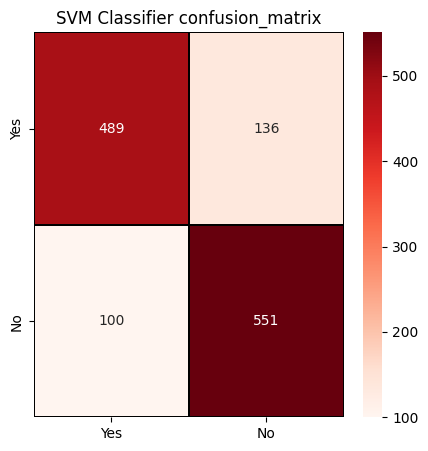

In [29]:
# Support Vector Machine Classifier
with mlflow.start_run(run_name='SVM', experiment_id=EXPERIMENT_ID):
    linear_svc = SVC(kernel='linear',gamma='scale')
    linear_svc.fit(x_train, y_train)

    predicted_qualities = linear_svc.predict(x_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(linear_svc.score(x, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(linear_svc, "model")
    print('Accuracy Score :- ',accuracy_score(y_test,predicted_qualities))
    print('Confusion Matrix \n ' ,confusion_matrix(y_test,predicted_qualities))
    print('classification Report \n :- ',classification_report(y_test,predicted_qualities))
    ## Confusion Matrix for Support Vector Machine Classifier.
    cm = confusion_matrix(y_test,predicted_qualities)
    x_axis_labels = ['Yes','No']
    y_axis_labels = ['Yes','No']
    f,ax = plt.subplots(figsize =(5,5))
    sns.heatmap(cm,annot=True,linewidths=.2,linecolor='black',fmt='.0f',ax=ax,cmap='Reds',xticklabels = x_axis_labels,yticklabels=y_axis_labels)
    plt.title('SVM Classifier confusion_matrix')
    mlflow.end_run()

/opt/conda/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/conda/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

  RMSE: 0.37558731437710074
  MAE: 0.14106583072100312
  R2: 0.4355023041474655
  Accuracy: 88.36
Accuracy Score:-  0.8589341692789969
Confusion Matrix:-  [[517 108]
 [ 72 579]]
Classifier Report:-                precision    recall  f1-score   support

           0       0.88      0.83      0.85       625
           1       0.84      0.89      0.87       651

    accuracy                           0.86      1276
   macro avg       0.86      0.86      0.86      1276
weighted avg       0.86      0.86      0.86      1276



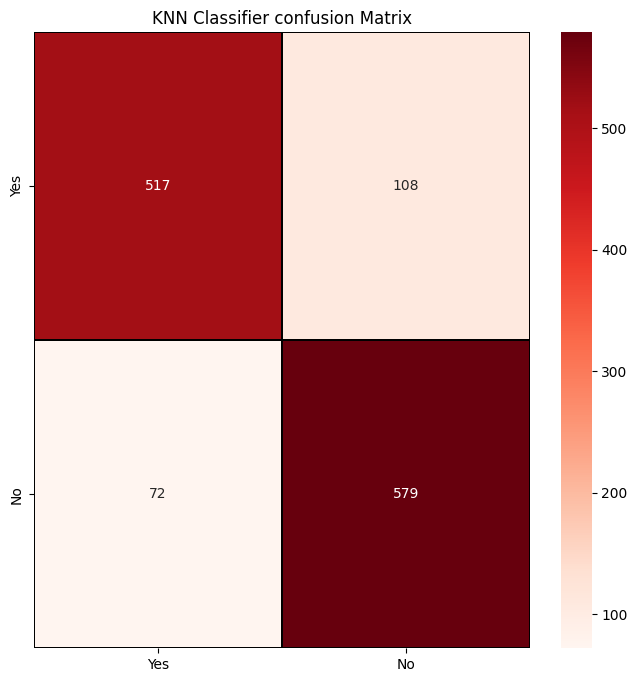

In [30]:
# KNN Classifier
with mlflow.start_run(run_name='KNN', experiment_id=EXPERIMENT_ID):
    knn = KNeighborsClassifier()
    knn.fit(x_train, y_train)

    predicted_qualities = knn.predict(x_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(knn.score(x, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(knn, "model")


    print('Accuracy Score:- ',accuracy_score(y_test,predicted_qualities))
    print('Confusion Matrix:- ',confusion_matrix(y_test,predicted_qualities))
    print('Classifier Report:- ', classification_report(y_test,predicted_qualities))
    ## Confusion Matrix for KNN Classifier.

    cm = confusion_matrix(y_test,predicted_qualities)
    x_axis_labels = ['Yes','No']
    y_axis_labels = ['Yes','No']
    f,ax = plt.subplots(figsize = (8,8))
    sns.heatmap(cm,annot=True,linewidths=.2,linecolor='black',fmt = '.0f',ax=ax,cmap='Reds',xticklabels = x_axis_labels,yticklabels = y_axis_labels)
    plt.title('KNN Classifier confusion Matrix')
    mlflow.end_run()

  RMSE: 0.3104754166210568
  MAE: 0.09639498432601881
  R2: 0.6142599078341013
  Accuracy: 98.41
GBC Accuracy Score is :  0.9036050156739812
GBC Confusion Matrix 
 [[564  61]
 [ 62 589]]
GBC Classification report 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       625
           1       0.91      0.90      0.91       651

    accuracy                           0.90      1276
   macro avg       0.90      0.90      0.90      1276
weighted avg       0.90      0.90      0.90      1276



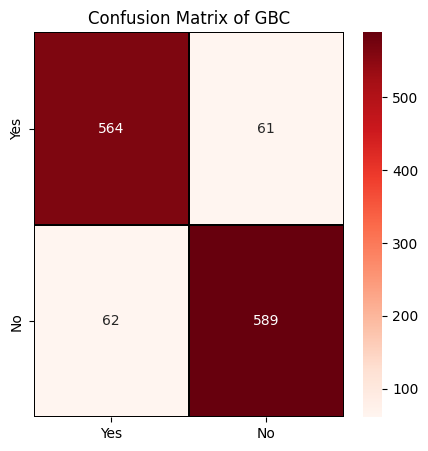

In [31]:
# Gradient Boosting Classifier
with mlflow.start_run(run_name='Gradient Boosting Classifier', experiment_id=EXPERIMENT_ID):
    gradient_boosting = GradientBoostingClassifier(n_estimators=100,learning_rate=0.8,max_depth=4)
    gradient_boosting.fit(x_train, y_train)

    predicted_qualities = gradient_boosting.predict(x_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(gradient_boosting.score(x, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(gradient_boosting, "model")
    print('GBC Accuracy Score is : ',accuracy_score(y_test,predicted_qualities))
    print('GBC Confusion Matrix \n',confusion_matrix(y_test,predicted_qualities))
    print('GBC Classification report \n',classification_report(y_test,predicted_qualities))
    ## Confusion Matrix for Gradient Boosting Classifier.
    cm = confusion_matrix(y_test,predicted_qualities)
    x_axis_labels = ['Yes','No']
    y_axis_labels = ['Yes','No']
    f,ax = plt.subplots(figsize = (5,5))
    sns.heatmap(cm,annot = True,linewidths=.2,linecolor='black',fmt='.0f',ax=ax,cmap='Reds',xticklabels = x_axis_labels,yticklabels = y_axis_labels)
    plt.title('Confusion Matrix of GBC')
    mlflow.end_run()

  RMSE: 0.2827318589675297
  MAE: 0.07993730407523511
  R2: 0.6801179723502304
  Accuracy: 9.86
The Accuracy of XGBC is:  0.9200626959247649
Confusion Matrix of XGBC :- 
  [[567  58]
 [ 44 607]]
classification report of XGBC:- 
                precision    recall  f1-score   support

           0       0.93      0.91      0.92       625
           1       0.91      0.93      0.92       651

    accuracy                           0.92      1276
   macro avg       0.92      0.92      0.92      1276
weighted avg       0.92      0.92      0.92      1276



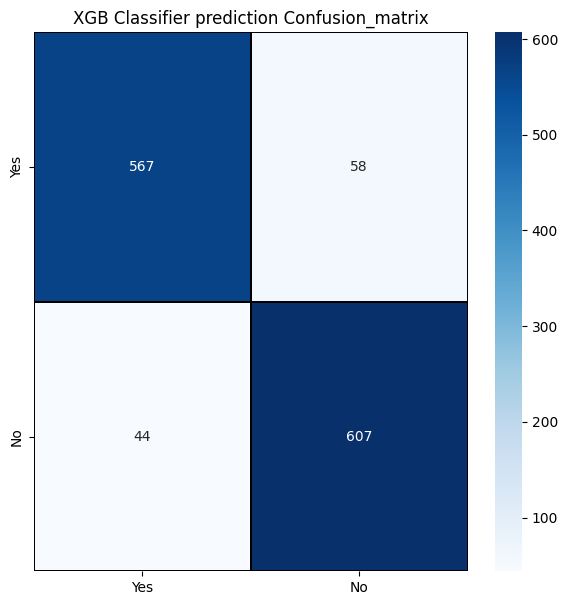

In [32]:
# XGB Classifier
with mlflow.start_run(run_name='XGB Classifier', experiment_id=EXPERIMENT_ID):
    xgbc = XGBClassifier()
    xgbc.fit(x_train, y_train)

    predicted_qualities = xgbc.predict(x_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(xgbc.score(x, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.xgboost.log_model(xgbc, 'model')

    print('The Accuracy of XGBC is: ',accuracy_score(y_test,predicted_qualities))
    print('Confusion Matrix of XGBC :- \n ', confusion_matrix(y_test,predicted_qualities))
    print('classification report of XGBC:- \n ', classification_report(y_test,predicted_qualities))
    ## Confusion Matrix for XGB Classifier.
    cm = confusion_matrix(y_test,predicted_qualities)
    x_axis_labels = ["Yes","No"]
    y_axis_labels = ["Yes","No"]

    f , ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cm, annot = True,linewidths=.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", 
    xticklabels=x_axis_labels,
    yticklabels=y_axis_labels)
    plt.title("XGB Classifier prediction Confusion_matrix")
    mlflow.end_run()

In [76]:
# Cross Validation Score for all the model
#    CV Score for Logistic Regrassion 
print('CV Score for logistic Regression :- ',cross_val_score(logreg,x,y,cv=5).mean())

#    CV Score for Random Forest Classifier

print('CV Score for Random Forest Classifier: ',cross_val_score(random_forest,x,y,cv=5).mean())

#    CV Score for Decision tree Classifier

print('CV score for Decision Tree Classifier',cross_val_score(decision_tree,x,y,cv=5).mean())


#    CV Score for support vector Classifire

print('CV Score for Support Vector Classifier ',cross_val_score(linear_svc,x,y,cv=5).mean())

#  CV Score for KNN classifier

print('CV Score for KNN Classifier',cross_val_score(knn,x,y,cv=5).mean())

#    CV Score for Gradian boosting Classifier

print('CV Score for Gradian Boosting Classifier',cross_val_score(gradient_boosting,x,y,cv=5).mean())

#   CV score for XGB Classifier

print('CV Score for XGB Classifier',cross_val_score(xgbc,x,y,cv=5).mean())

CV Score for logistic Regression :-  0.8038015240913792
CV Score for Random Forest Classifier:  0.9030322938535498
CV score for Decision Tree Classifier 0.8620005789087914
CV Score for Support Vector Classifier  0.8065051248626128


/opt/conda/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/conda/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

CV Score for KNN Classifier 0.8386072062400565
CV Score for Gradian Boosting Classifier 0.8910425263082267
CV Score for XGB Classifier 0.901153948980036


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

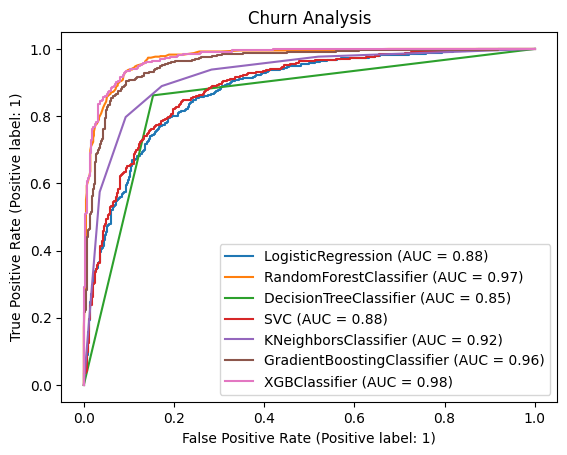

In [61]:
### From the observation of accuracy and cross validation score and their difference we can predict that Random Forest Classifier is the best model.
disp = plot_roc_curve(logreg,x_test,y_test)
plot_roc_curve(random_forest,x_test,y_test,ax=disp.ax_)
plot_roc_curve(decision_tree,x_test,y_test,ax=disp.ax_)
plot_roc_curve(linear_svc,x_test,y_test,ax=disp.ax_)
plot_roc_curve(knn,x_test,y_test,ax=disp.ax_)
plot_roc_curve(gradient_boosting,x_test,y_test,ax=disp.ax_)
plot_roc_curve(xgbc,x_test,y_test,ax=disp.ax_)

plt.title('Churn Analysis')
plt.legend(prop={'size' : 10},loc = 'lower right')
plt.show()

In [72]:
# Hyper Perametertuning for best model using GridsearchCV
# The XGB Classifier with GridsearchCV
params = {
    
    'n_estimators' : [100,200,500],
    'learning_rate' : [0.01,0.05,0.01],
    'booster': ['gbtree', 'gblinear'],
    'reg_alpha' : [0,0.5,1],
    'reg_lambda': [0.5,1,5],
    'base_score': [0.2,0.5,1]
}
CV_XGBC = GridSearchCV(XGBClassifier(n_jobs=-1),params,n_jobs=-1,cv = KFold(n_splits=3),scoring='roc_auc')
CV_XGBC.fit(x_train,y_train)
CV_XGBC.best_params_ 
CV_XGBC.best_estimator_
bank = XGBClassifier(base_score=0.2,booster='gbtree',learning_rate=0.1,n_estimators = 500, reg_alpha=0.5,reg_lambda=1)
bank.fit(x_train,y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
486 fits failed out of a total of 1458.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/opt/conda/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    

XGBClassifier(base_score=0.2, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

[06:56:51] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:51] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:52] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:52] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:52] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:53] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:53] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:53] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:54] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:54] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:54] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:56:54] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[06:

Accuracy Score 0.9231974921630094

  confusion matrix  
 [[572  53]
 [ 45 606]]

  Classification_matrix  
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       625
           1       0.92      0.93      0.93       651

    accuracy                           0.92      1276
   macro avg       0.92      0.92      0.92      1276
weighted avg       0.92      0.92      0.92      1276



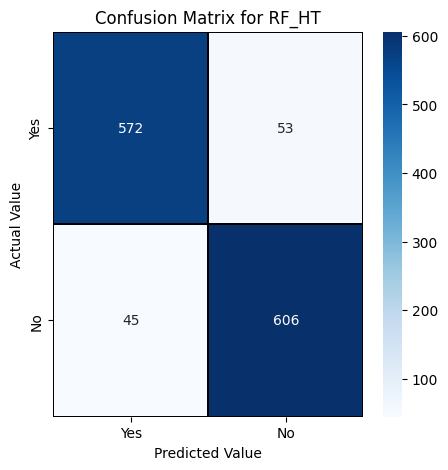

In [63]:
# Here the final model gives 90% accuracy after tuning.
pred=bank.predict(x_test)
print('Accuracy Score',accuracy_score(y_test,pred))
print('\n  confusion matrix  \n',confusion_matrix(y_test,pred))
print('\n  Classification_matrix  \n',classification_report(y_test,pred))

cm = confusion_matrix(y_test,pred)
x_axis_labels = ['Yes','No']
y_axis_labels = ['Yes','No']
f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot=True,linewidths=0.2,linecolor='black',fmt = '.0f',ax=ax,cmap='Blues',xticklabels=x_axis_labels,yticklabels=y_axis_labels)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Confusion Matrix for RF_HT')
plt.show()

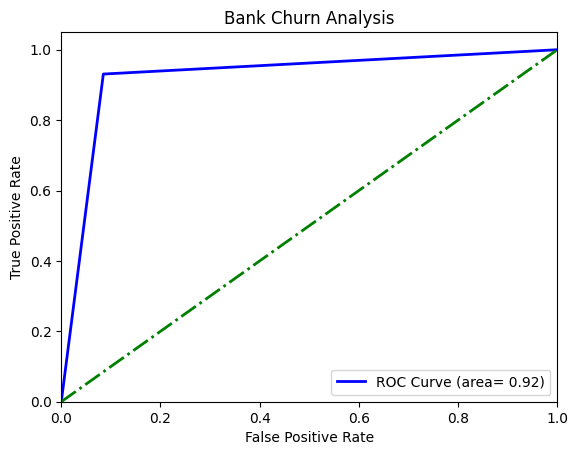

In [64]:
# ROC-AUC Curve
fpr,tpr,threshold = roc_curve(y_test,pred)
auc = roc_auc_score(y_test,pred)
plt.figure()
plt.plot(fpr,tpr,color="blue",lw=2,label="ROC Curve (area= %0.2f)" % auc)
plt.plot([0,1],[0,1],color="green",lw=2,linestyle="dashdot")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Bank Churn Analysis")
plt.legend(loc="lower right")
plt.show()

# This is the AUC-ROC curve for the models which is plotted False positive rate against True positive rate. So the best model has the area under curve as 0.90.

In [65]:
# Saving The Model
import pickle
filename = 'Bank_Churn_Analysis.pickle'
pickle.dump(random_forest,open(filename,'wb'))
loaded_model = pickle.load(open(filename,'rb'))
loaded_model.predict(x_test)

a = np.array(y_test)
predicted = np.array(loaded_model.predict(x_test))
Customer_Churn_Analysis = pd.DataFrame({'Original': a, 'Predicted': predicted}, index=range(len(a)))
Customer_Churn_Analysis

Original  Predicted
0            1          1
1            1          1
2            1          1
3            0          0
4            0          0
...        ...        ...
1271         0          0
1272         1          1
1273         0          1
1274         0          0
1275         1          1

[1276 rows x 2 columns]

In [66]:
from minio import Minio
EXPERIMENT_ID = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

# print(os.getenv("MLFLOW_S3_ENDPOINT_URL").replace("https://",""))
# print(os.getenv("AWS_ACCESS_KEY_ID"))
# print(os.getenv("AWS_SECRET_ACCESS_KEY"))

client = Minio(
    endpoint=os.getenv("MLFLOW_S3_ENDPOINT_URL").replace("https://",""),
    access_key=os.getenv("AWS_ACCESS_KEY_ID"),
    secret_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    secure=True,
    http_client = urllib3.PoolManager(cert_reqs='CERT_NONE')
)


In [67]:
from mlflow import pyfunc
best_run_df = mlflow.search_runs(experiment_ids=[EXPERIMENT_ID], order_by=['metrics.accuracy DESC'], max_results=1)
best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
best_model_uri = f"{best_run.info.artifact_uri}/model"
is_xgbc = best_run.info.run_name == "XGB Classifier"
# best_model = pyfunc.load_model(best_model_uri)

print("Best run info:")
print(f"Run id: {best_run.info.run_id}")
print("Run Accuracy:  = {:.4f}\n".format(best_run.data.metrics['accuracy']))
print(f"Run model URI: {best_model_uri}")

Best run info:
Run id: 1d56877964a045ed99ad616da6d11c0d
Run Accuracy:  = 98.7900

Run model URI: s3://mlflow/3/1d56877964a045ed99ad616da6d11c0d/artifacts/model


In [68]:
import subprocess

api_version = 'serving.kserve.io/v1beta1'
model_name = 'bank-demo-1'
model_namespace = 'hpedemo-user01'

inference_service = '''
apiVersion: "{}"
kind: "InferenceService"
metadata:
  name: {}
  namespace: {}
spec:
  predictor:
    serviceAccountName: kserve-minio-sa
    {}:
      protocolVersion: "v2"
      storageUri: "{}"
'''.format(api_version, model_name, model_namespace, "sklearn" if not is_xgbc else "xgboost", best_model_uri)

subprocess.run('cat << EOF | kubectl apply -f -' + inference_service + 'EOF', shell=True)

inferenceservice.serving.kserve.io/bank-demo-1 configured


CompletedProcess(args='cat << EOF | kubectl apply -f -\napiVersion: "serving.kserve.io/v1beta1"\nkind: "InferenceService"\nmetadata:\n  name: bank-demo-1\n  namespace: hpedemo-user01\nspec:\n  predictor:\n    serviceAccountName: kserve-minio-sa\n    sklearn:\n      protocolVersion: "v2"\n      storageUri: "s3://mlflow/3/1d56877964a045ed99ad616da6d11c0d/artifacts/model"\nEOF', returncode=0)

In [69]:
import requests, json
import numpy as np
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

KUBEFLOW_URL = "kubeflow.hpe-apps-dev2-ezaf.com"
DEPLOYMENT_NAME = "bank-demo-1"
NAMESPACE="hpedemo-user01"
SVC = f'{DEPLOYMENT_NAME}-predictor-default.{NAMESPACE}.hpe-apps-dev2-ezaf.com'

URL = "https://{}/v2/model/{}/infer".format(SVC, DEPLOYMENT_NAME)

# PREDICTION_URL = KUBEFLOW_URL #"{}/seldon/{}/{}/api/v1.0/predictions".format(KUBEFLOW_URL,NAMESPACE,SELDON_DEPLOYMENT_NAME)
print(URL)

https://bank-demo-1-predictor-default.hpedemo-user01.hpe-apps-dev2-ezaf.com/v2/model/bank-demo-1/infer


In [70]:
import requests
EZAF_ENV = "hpe-apps-dev2-ezaf"
token_url = f"https://keycloak.{EZAF_ENV}.com/realms/UA/protocol/openid-connect/token"

data = {
    "username" : input("Enter username."),
    "password" : input("Enter password."),
    "grant_type" : "password",
    "client_id" : "ua-grant",
}

token_responce = requests.post(token_url, data=data, allow_redirects=True, verify=False)

token = token_responce.json()["access_token"]




Enter username. hpedemo-user01
Enter password. Hpepoc@123


In [71]:
NAMESPACE = "hpedemo-user01"
DEPLOYMENT_NAME = "bank-demo-1"
MODEL_NAME = DEPLOYMENT_NAME
SVC = f'{DEPLOYMENT_NAME}-predictor-default.{NAMESPACE}.{EZAF_ENV}.com'
URL = f"https://{SVC}/v2/models/{MODEL_NAME}/infer"

print(URL)

names=['age','job','marital','education','default1','balance','housing','loan','contact',
       'day','month','duration','campaign','pdays','previous','poutcome','target']

input_data = [
    [30,'unemployed','married','primary','no',1787,'no','no','cellular',19,'oct',79,1,-1,0,'unknown','no'],
    [36,'self-employed','married','tertiary','no',307,'yes','no','cellular',14,'may',341,1,330,2,'other','no']
]

Declined = {'age':30,'job':'unemployed','marital':'married','education':'primary','default1':'no','balance':1787,'housing':'no','loan':'no','contact':'cellular',
       'day':19,'month':'oct','duration':79,'campaign':1,'pdays':-1,'previous':0,'poutcome':'unknown'} #,'target':'no'}

Approved={'age':20,'job':'student','marital':'single','education':'secondary','default1':'no','balance':502,'housing':'no','loan':'no','contact':'cellular',
       'day':30,'month':'apr','duration':261,'campaign':1,'pdays':1,'previous':0,'poutcome':'unknown'} #,'target':'yes'}

enc = LabelEncoder()
for key, value in Declined.items():
    if isinstance(value, str):
        Declined[key] = 0.5 ## TODO

for key, value in Approved.items():
    if isinstance(value, str):
        Approved[key] = 0.5 ## TODO

inputs = {
  "inputs": [
    { 
      "name": "ndarray",
      "shape": [2,16], # 17],
      "datatype": "FP32",
      "data": [
        list(Approved.values()),
        list(Declined.values())  
      ]
    }
  ],
    "outputs": [
        {
            "name": "predict"
        },
        {
            "name": "predict_proba"
        }
    ]
}

headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
     "Authorization": f"Bearer {token}"
}
json_request = json.dumps(inputs)
print(json_request)
response = requests.post(URL, headers=headers, data=json_request, verify=False)
print(response.reason)
outputs = response.json()["outputs"]
print(outputs)

# response = requests.post(URL, json=inputs, headers=headers, verify=False)

# print(response.reason)

# output = response.json()['outputs']

# print("eligible for investment banking\n")
# for item, out in zip(input_data, output):
#     input_dict = dict(zip(names,item))
#     print(f"Input Data: {input_dict} \n\ntarget customers{out}\n")


https://bank-demo-1-predictor-default.hpedemo-user01.hpe-apps-dev2-ezaf.com/v2/models/bank-demo-1/infer
{"inputs": [{"name": "ndarray", "shape": [2, 16], "datatype": "FP32", "data": [[20, 0.5, 0.5, 0.5, 0.5, 502, 0.5, 0.5, 0.5, 30, 0.5, 261, 1, 1, 0, 0.5], [30, 0.5, 0.5, 0.5, 0.5, 1787, 0.5, 0.5, 0.5, 19, 0.5, 79, 1, -1, 0, 0.5]]}], "outputs": [{"name": "predict"}, {"name": "predict_proba"}]}
OK
[{'name': 'predict', 'shape': [2], 'datatype': 'INT64', 'parameters': None, 'data': [1, 1]}, {'name': 'predict_proba', 'shape': [2, 2], 'datatype': 'FP64', 'parameters': None, 'data': [0.42, 0.58, 0.48, 0.52]}]
